# Parkinson's Disease Speech Data Analysis
## Eric Hansen
### Flatiron Data Science Self Paced, 2020-2021, Phase 3 Project

Parkinson's is a long-term degenerative disorder of the human nervous system.  Mainly affecting the motor system, patients with Parkinson's (PWP) have symptoms including tremor, slowness of movement, and difficulty walking and speaking.
Parkinson's affects approximately seven million people globally and one million people in the US.  Though it affects people much younger, the usual onset is later than age 60, rising from 1% in those 60 or older to 4% of the population over 80.
https://en.wikipedia.org/wiki/Parkinson's_disease

There exist certain diagnosis metrics (UPDRS) which measure a variety of different factors of patient behavior in order to diagnose Parkinson's.  These existing metrics include a measurement of speech impairment, but there is potential to improve upon this particular metric using a data scientific classification approach.  Ideally, this could be used to make earlier and more sensitive diagnoses than are currently the norm.  

# Source of Data: 

Erdogdu Sakar, B., Isenkul, M., Sakar, C.O., Sertbas, A., Gurgen, F., Delil, S., Apaydin, H., Kursun, O., 'Collection and Analysis of a Parkinson Speech Dataset with Multiple Types of Sound Recordings', IEEE Journal of Biomedical and Health Informatics, vol. 17(4), pp. 828-834, 2013.

As found on  
https://archive.ics.uci.edu/ml/datasets/Parkinson+Speech+Dataset+with++Multiple+Types+of+Sound+Recordings#

And available    
https://www.researchgate.net/publication/260662600_Collection_and_Analysis_of_a_Parkinson_Speech_Dataset_With_Multiple_Types_of_Sound_Recordings

NB: The data found here are not raw sound files.  It has already been processed, filtered, and decomposed to extract numerous frequency, amplitude, and other metrics, which are found in this data set.

# Lots of imports

In [1]:
import sys
sys.version

'3.8.5 | packaged by conda-forge | (default, Sep 24 2020, 16:20:24) [MSC v.1916 64 bit (AMD64)]'

In [2]:
#Verbose flag - turn True for additional reporting in following cells, turn False for more concise, shorter output.
verbose = False

In [3]:
use_default_cv=True
if use_default_cv:
    cv_def = 5
else:
    cv_def = None

In [4]:
#random_state handling
from random import randrange
is_random=False
if is_random:
    random_state_val = randrange(1, 500)
else:
    random_state_val = 7
if verbose:
    print('Random State Value Used this Run:', random_state_val)

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')
# Import the data
#training_target_df = pd.read_csv('data\Parkinson_Multiple_Sound_Recording\train_data.txt')

sample_descriptions = ['sust_a', 'sust_o', 'sust_u', 'num01', 'num02', 'num03', 'num04', 'num05', 'num06', 'num07', 'num08', 'num09', 
              'num10', 'sentence1', 'sentence2', 'sentence3', 'word1 through word9']
colheadings_train = ['ID', 
               'jitter_local', 'jitter_local_abs', 'jitter_rap', 'jitter_ppq5', 'jitter_ddp',
               'shimmer_local', 'shimmer_local_dB', 'shimmer_apq3', 'shimmer_apq5', 'shimmer_apq11', 'shimmer_dda',
               'AC', 'NTH', 'HTN',
               'median_pitch', 'mean_pitch', 'std_dev', 'min_pitch', 'max_pitch',
               'num_pulses', 'num_periods', 'mean_period', 'std_dev_of_period', 
               'fraction_of_locally_unvoiced_frames', 'num_voice_breaks', 'degree_of_voice_breaks',
                'UPDRS', 'class_info'
              ]
colheadings_test = ['ID', 
               'jitter_local', 'jitter_local_abs', 'jitter_rap', 'jitter_ppq5', 'jitter_ddp',
               'shimmer_local', 'shimmer_local_dB', 'shimmer_apq3', 'shimmer_apq5', 'shimmer_apq11', 'shimmer_dda',
               'AC', 'NTH', 'HTN',
               'median_pitch', 'mean_pitch', 'std_dev', 'min_pitch', 'max_pitch',
               'num_pulses', 'num_periods', 'mean_period', 'std_dev_of_period', 
               'fraction_of_locally_unvoiced_frames', 'num_voice_breaks', 'degree_of_voice_breaks',
               'class_info'
              ]
train_df = pd.read_csv('data/Parkinson_Multiple_Sound_Recording/train_data.txt', sep=",", header=None, names=colheadings_train)
test_df = pd.read_csv('data/Parkinson_Multiple_Sound_Recording/test_data.txt', sep=",", header=None, names=colheadings_test)
#training_df.columns = colheadings
#test_df = pd.read_csv('data\Parkinson_Multiple_Sound_Recording\test_data.txt', sep=",", header=None)
#st_unlabeled_df = pd.read_csv('data\Parkinson_Multiple_Sound_Recording\water_test-Copy1.csv')

In [7]:
# Train and test set classification inspection
train_df['class_info'].value_counts()

1    520
0    520
Name: class_info, dtype: int64

In [8]:
test_df['class_info'].value_counts()

1    168
Name: class_info, dtype: int64

Note that the training data is 50/50 Patients With Parkinsons (PWP) / non-PD patients, but the test data is 100% PWP.  
It may be more appropriate to consider cross-validation accuracy rates on the training set.  For the testset, we should consider alternative metrics.  We could try to oversample non-PD patients on the test set, but there aren't any.  

Ultimately, which metric is appropriate for this setting?  If our goal were to be early detection or flagging in order to begin treatment, we'd want a metric that minimizes false negatives, at the risk of some false positives (which would have impact, but minimal impact, unless it lead to an erroneous treatment that may have side effects, but hopefully those could be counteracted by further testing).  Recall is a good candidate for primary metric here, though we may also still take a look at accuracy and f1 for additional perspective.

# Definitions  

For each patient, several voice samples are taken, then 26 features are extracted using commonly used analysis of those samples.  

"In this context, during medical ex-aminations, each subject is asked to read or say predetermined26 voice samples containing numbers from 1 to 10, four rhymedsentences, nine words in Turkish language along with sustainedvowels “a”, “o”, and “u.” To extract features from voice samples,Praat acoustic analysis software is used. A group of 26 linearand time-frequency based features are extracted fromeach voice sample considering the previous works held on this ﬁeld of study."  

(Sources for following: https://www.sciencedirect.com/science/article/pii/S2212017313002788   
https://www.fon.hum.uva.nl/praat/manual/Voice_2__Jitter.html  
)  

## Frequency parameters
Jitter is a measure that reflects the variation of the successive periods; analysis estimates the underlying timing of the fundamental period.  It is a frequency variation metric.

Jitter (local): Represents the average absolute difference between two consecutive periods, divided by the 
average period.  

Jitter (local, abs): Represents the average absolute difference between two consecutive periods.  

Jitter (rap): Represents the average for the disturbance, i.e., the average absolute difference of one period 
and the average of the period with its two neighbors, divided by the average period.  

Jitter (ppq5): Represents the ratio of disturbance within five periods, i.e., the average absolute difference 
between a period and the average containing its four nearest neighbor periods, i.e. two previous and two 
subsequent periods, divided by average period.  

Jitter (ddp): This is the average absolute difference between consecutive differences between consecutive periods, divided by the average period.  

## Amplitude Parameters
Shimmer is a measure that reflects variation of the amplitude over time; it is an amplitude variation metric, with respect to the maximum peak amplitude.  

Shimmer (local): Represents the average absolute difference between the amplitudes of two consecutive 
periods, divided by the average amplitude. 

Shimmer (local, dB): Represents the average absolute difference of the base 10 logarithm of the difference 
between two consecutive periods.  

Shimmer (apq3): represents the quotient of amplitude disturbance within three periods, in other words, the 
average absolute difference between the amplitude of a period and the mean amplitudes of its two neighbors, 
divided by the average amplitude. 

Shimmer (apq5): Represents the ratio of perturbation amplitude of five periods, in other words, the average 
absolute difference between the amplitude of a period and the mean amplitudes of it and its four nearest 
neighbors, divided by the average amplitude. 

## Harmonicity Parameters
HTN: Harmonic to noise ratio.  (I would interpret this as a measure of the "purity" of pitch, relative to extraneous pitches).
ratio of ACfundamental to difference between ACfundamental and ACfirst harmonic.
NTH:  Noise to Harmonic ratio.  

AC: Autocorrelation - in general, a mathematical representation of the degree of similarity between a given time series and a lagged version of itself over successive time intervals; i.e., the correlation of a signal with itself in later time periods. (In this case, this may be adjusted to have to do with the value of the first peak of the period graph - represents the fundamental frequency; used in HTN and NTH)

## Pitch Parameters
Pitch: how the human ear perceives sound frequencies - e.g. high/low.  The note or tone or sound frequency.
Median Pitch, mean pitch, std_dev, min_pitch, max_pitch: descriptive stats for pitch.

## Pulse parameters
Period: in general, the reciprocal of frequency - the length in time of one cycle.  In context of pulse, however, this may have additional connotation.
Pulse: in general, a rapid, transient change from a baseline signal to a different value, followed by a rapid return to baseline.  
Num_pulses, num_periods, mean_period, std_dev_of_period: descriptives for period

## Voicing Parameters
(source: https://fon.hum.uva.nl/praat/manual/Voice_1__Voice_breaks.html)  
fraction_of_locally_unvoiced_frames: This is the fraction of pitch frames that are analysed as unvoiced; subject to a pitch floor.

Number of voice breaks: The number of distances between consecutive pulses that are longer than 1.25 divided by the pitch floor. Thus, if the pitch floor is 75 Hz, all inter-pulse intervals longer than 16.6667 milliseconds are regarded as voice breaks.

Degree of voice breaks: This is the total duration of the breaks between the voiced parts of the signal, divided by the total duration of the analysed part of the signal 


UPDRS: Uniﬁed Parkinson’s Disease Rating Scale; inconsistent between train/test set, so unused.  
    See https://www.theracycle.com/resources/links-and-additional-resources/updrs-scale/ for details

Class_info: target column, whether or not the patient has Parkinson's Disease


# Discussion:
Some potential engineered features include binning for some numerical values.
One useful feature to have would be gender, (of course, ultimately we would refine the process to take into account people who are transgender, intersex et al); since we aren't given that, we may be able to estimate that using pitch features.  There are a variety of studies that investigate pitch as a predictor, while others others indicate timbre as a predictor.  Since our data includes pitch, we will work with that.

In discussion with a speech pathologist, one major indicator of PD is oral festination.  Another indicator is speaking in monotone.

"In Parkinson's disease (PD), festination corresponds to a tendency to speed up when performing repetitive movements. First described in gait (and then in handwriting and speech), festination is one of the most disabling axial symptoms" - https://pubmed.ncbi.nlm.nih.gov/17516477/

These indicator doesn't seem to be represented directly from existing features; however, may be able to be engineered, or, failing that, we may recognize in the parameters of our final models some representative of these indicators.

# Exploratory Data Analysis

In [9]:
train_df.head()

,ID,jitter_local,jitter_local_abs,jitter_rap,jitter_ppq5,jitter_ddp,shimmer_local,shimmer_local_dB,shimmer_apq3,shimmer_apq5,...,max_pitch,num_pulses,num_periods,mean_period,std_dev_of_period,fraction_of_locally_unvoiced_frames,num_voice_breaks,degree_of_voice_breaks,UPDRS,class_info
0,1,1.488,0.000090,0.900,0.794,2.699,8.334,0.779,4.517,4.609,...,187.576,160,159,0.006065,0.000416,0.000,0,0.000,23,1
1,1,0.728,0.000038,0.353,0.376,1.059,5.864,0.642,2.058,3.180,...,234.505,170,169,0.005181,0.000403,2.247,0,0.000,23,1
2,1,1.220,0.000074,0.732,0.670,2.196,8.719,0.875,4.347,5.166,...,211.442,1431,1427,0.006071,0.000474,10.656,1,0.178,23,1
3,1,2.502,0.000123,1.156,1.634,3.469,13.513,1.273,5.263,8.771,...,220.230,94,92,0.004910,0.000320,0.000,0,0.000,23,1
4,1,3.509,0.000167,1.715,1.539,5.145,9.112,1.040,3.102,4.927,...,225.162,117,114,0.004757,0.000380,18.182,1,13.318,23,1


In [10]:
print(f'{train_df.shape[0]} samples and {train_df.shape[1]} features in the Parkinsons Disease dataset.')

1040 samples and 29 features in the Parkinsons Disease dataset.


In [11]:
#Some basic data integrity checks 
if verbose:
    display(train_df.groupby('ID').count().head())
    display(train_df.groupby('class_info').max().head())
    display(train_df.groupby('class_info').min().head())
    display(train_df.groupby('class_info').count().head())
    display(train_df['class_info'].value_counts())

In [12]:
if verbose:
    test_df.head()

In [13]:
# Data Type inspection
if verbose:
    display(train_df.head())
    display(train_df.info())

In [14]:
#N/A check
if verbose:
    train_df.isna().sum()

In [15]:
#UPDRS and class info correlation check
if verbose: 
    display(train_df['UPDRS'].value_counts())
    display(train_df['class_info'].value_counts())

# Metrics  
Let's define some metrics - the usuals, plus a new one mentioned in the research paper that provided this data, namely MCC (Matthews Correlation Coefficient). Unfortunately, MCC is undefined for sets that are all positive, but we can still use it for perspective on our training set.  

Note that many of these are already implemented into many of the models we use, but I will provide these here just in case they're needed in a pinch.

Also, among the other usual suspects, recall will be at a premium here because it better represents when costs of False Negatives are high (i.e. if we miss a PWP, that is a significant problem; moreso than a false positive).


In [16]:
def precision(y, y_hat):
    # Your code here
    # precision = true positives / all predicted positives
#     resid = y-y_hat
    cmatrix = {'TP':0, 'FN':0, 'FP':0, 'TN':0}
    lt = list(y)
    lp = list(y_hat)
    for i in range(len(lt)):
        if lt[i] == 1 and lp[i] == 1:
            cmatrix['TP'] = cmatrix.get('TP', 0) + 1
        elif lt[i] == 1 and lp[i] == 0:
            cmatrix['FN'] = cmatrix.get('FN', 0) + 1
        elif lt[i] == 0 and lp[i] == 1:
            cmatrix['FP'] = cmatrix.get('FP', 0) + 1            
        elif lt[i] == 0 and lp[i] == 0:
            cmatrix['TN'] = cmatrix.get('TN', 0) + 1    
    return cmatrix['TP']/(cmatrix['TP']+cmatrix['FP'])
    
    
def recall(y, y_hat):
    # Your code here
    # recall = true pos / actual total positives
    cmatrix = {'TP':0, 'FN':0, 'FP':0, 'TN':0}
    lt = list(y)
    lp = list(y_hat)
    for i in range(len(lt)):
        if lt[i] == 1 and lp[i] == 1:
            cmatrix['TP'] = cmatrix.get('TP', 0) + 1
        elif lt[i] == 1 and lp[i] == 0:
            cmatrix['FN'] = cmatrix.get('FN', 0) + 1
        elif lt[i] == 0 and lp[i] == 1:
            cmatrix['FP'] = cmatrix.get('FP', 0) + 1            
        elif lt[i] == 0 and lp[i] == 0:
            cmatrix['TN'] = cmatrix.get('TN', 0) + 1    
    return cmatrix['TP']/(cmatrix['TP']+cmatrix['FN'])

def accuracy(y, y_hat):
    # Your code here
    # accuracy  = (number of true pos + true neg)/ total obs
    cmatrix = {'TP':0, 'FN':0, 'FP':0, 'TN':0}
    lt = list(y)
    lp = list(y_hat)
    for i in range(len(lt)):
        if lt[i] == 1 and lp[i] == 1:
            cmatrix['TP'] = cmatrix.get('TP', 0) + 1
        elif lt[i] == 1 and lp[i] == 0:
            cmatrix['FN'] = cmatrix.get('FN', 0) + 1
        elif lt[i] == 0 and lp[i] == 1:
            cmatrix['FP'] = cmatrix.get('FP', 0) + 1            
        elif lt[i] == 0 and lp[i] == 0:
            cmatrix['TN'] = cmatrix.get('TN', 0) + 1    
    return (cmatrix['TP']+cmatrix['TN'])/len(y)

def f1_score(y, y_hat):
    # Your code here
    # 2(precision*recall)/(precision+recall)
    prec = precision(y, y_hat)
    rec = recall(y, y_hat)
    return 2*(prec*rec)/(prec+rec)

def mcc(y, y_hat):
    #This is also known as Matthews Correlation Coefficient
    #MCC =(TPxTN −FPxFN) / sqrt((TP +FP)(TP +FN)(TN +FP)(TN +FN))
    #### This metric does have issues when there are no negatives in the set - namely, in the test set we have####
    
    cmatrix = {'TP':0, 'FN':0, 'FP':0, 'TN':0}
    lt = list(y)
    lp = list(y_hat)
    for i in range(len(lt)):
        if lt[i] == 1 and lp[i] == 1:
            cmatrix['TP'] = cmatrix.get('TP', 0) + 1
        elif lt[i] == 1 and lp[i] == 0:
            cmatrix['FN'] = cmatrix.get('FN', 0) + 1
        elif lt[i] == 0 and lp[i] == 1:
            cmatrix['FP'] = cmatrix.get('FP', 0) + 1            
        elif lt[i] == 0 and lp[i] == 0:
            cmatrix['TN'] = cmatrix.get('TN', 0) + 1
    TP = cmatrix['TP']
    TN = cmatrix['TN']
    FP = cmatrix['FP']
    FN = cmatrix['FN']
    return ((TP*TN - FP*FN) / np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)))

def score_suite(y, y_hat):
    results = []
    testnames = ['precision', 'recall', 'accuracy', 'f1_score', 'mcc']
    tests = [precision, recall, accuracy, f1_score, mcc]
    for test in tests:
        results.append(test(y,y_hat))
    return [testnames, results]
#score_suite(y_train, y_pred)

# Initial inspection of predictor/target variables  
Since the target variable is binary, scatter plot isn't much use, but we can do a distribution plot of all the predictors to see how they are arranged.

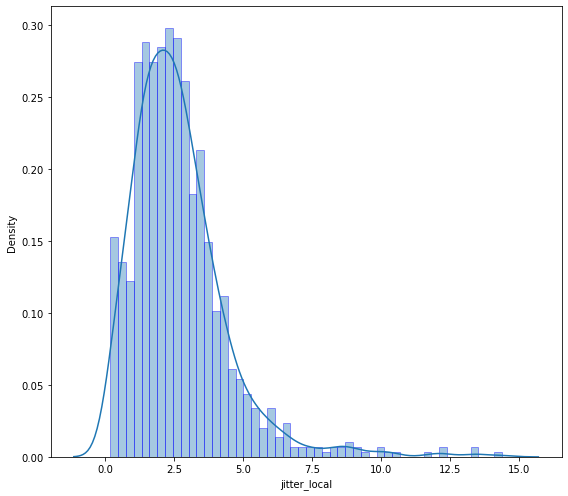

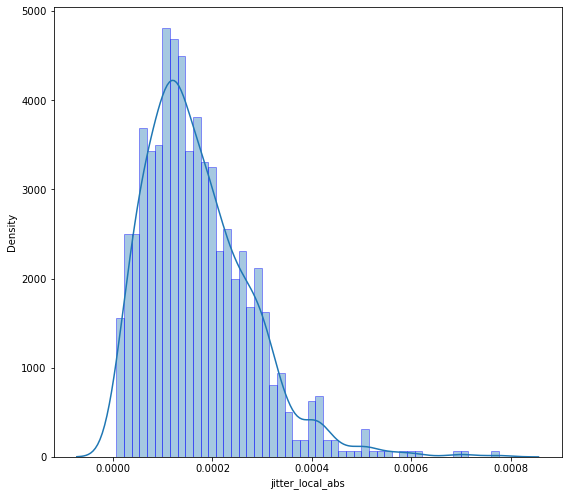

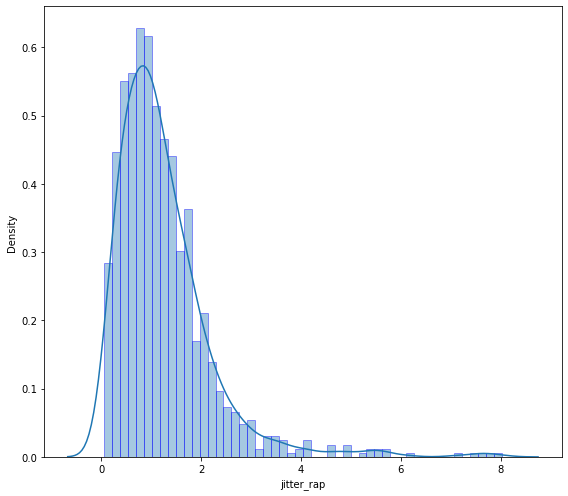

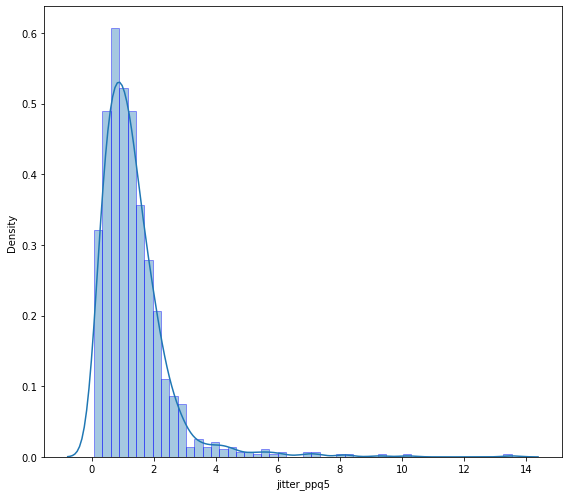

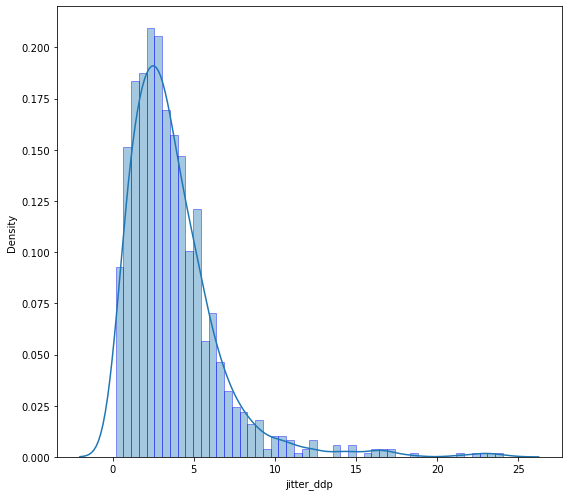

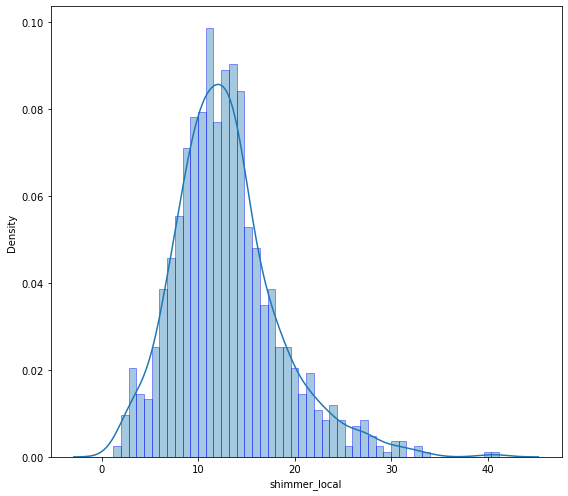

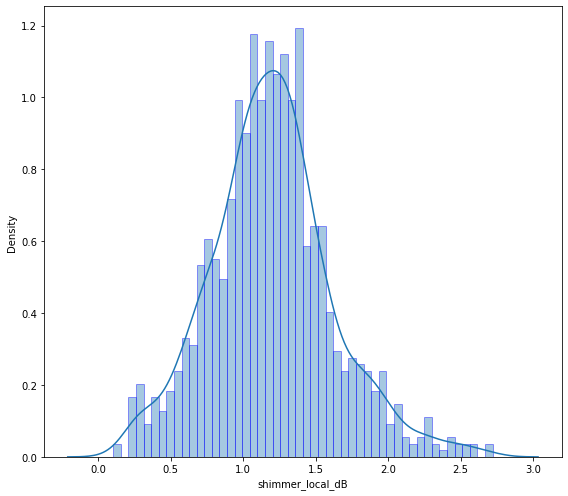

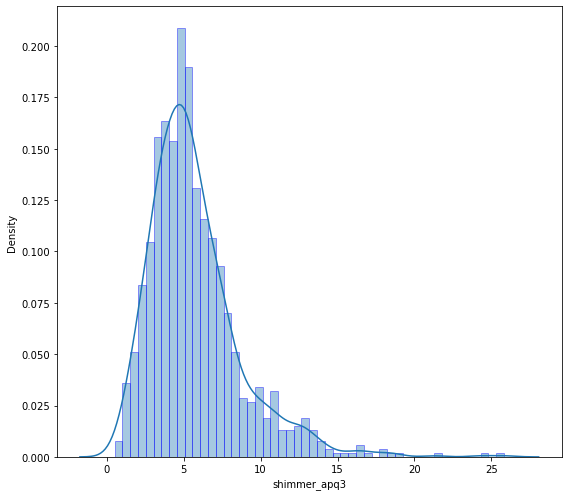

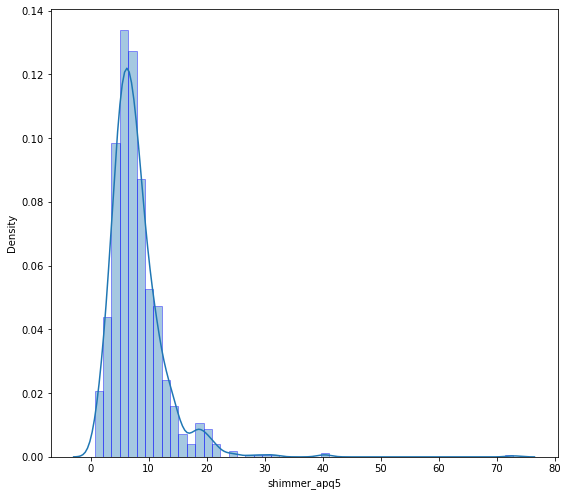

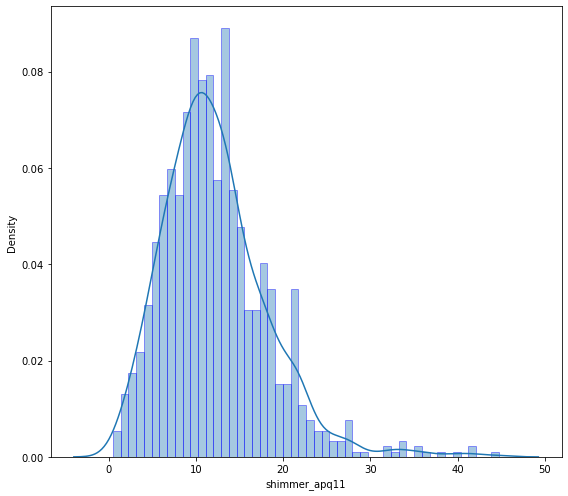

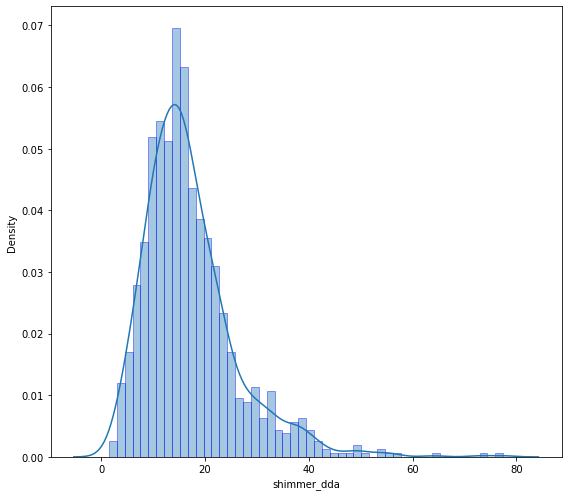

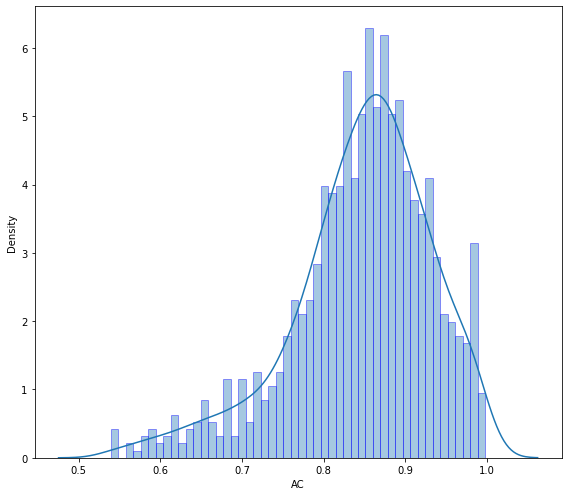

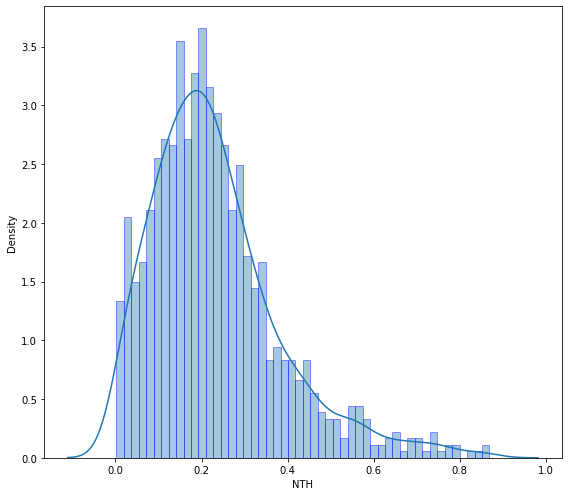

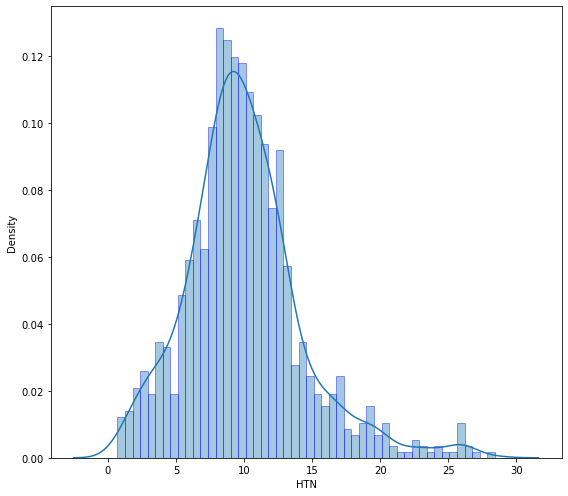

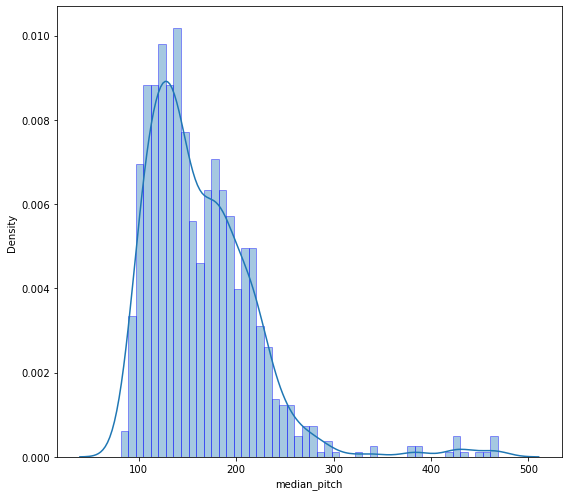

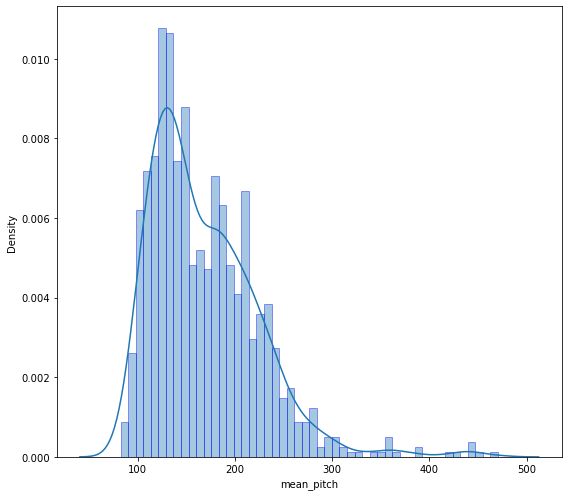

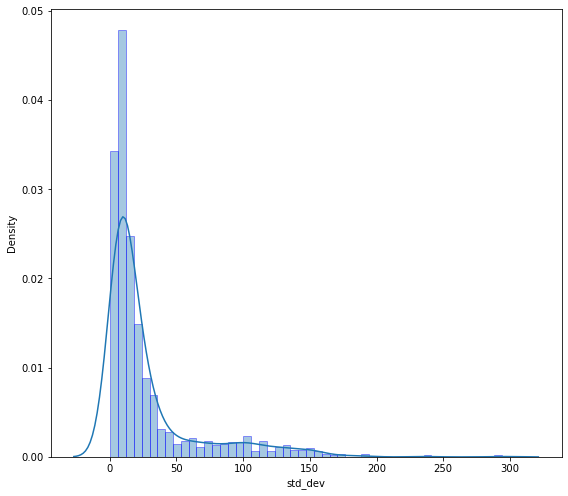

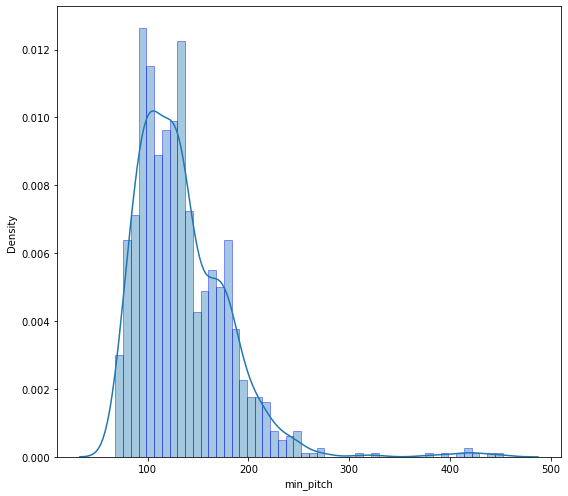

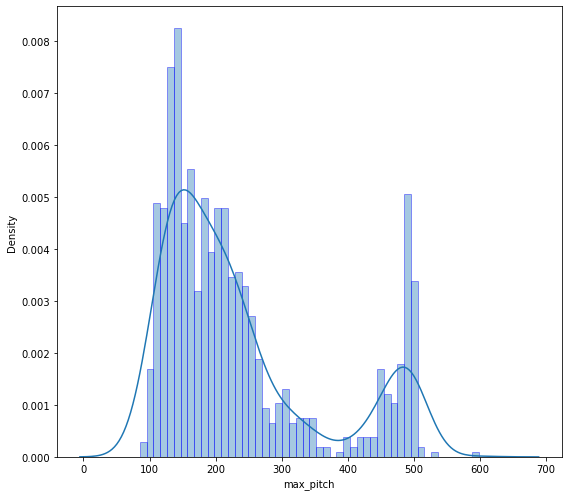

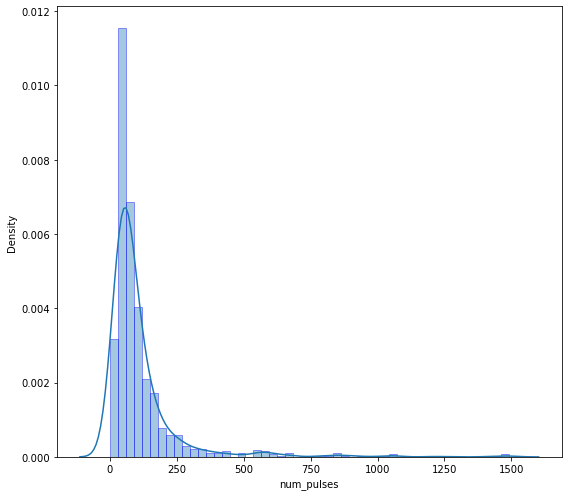

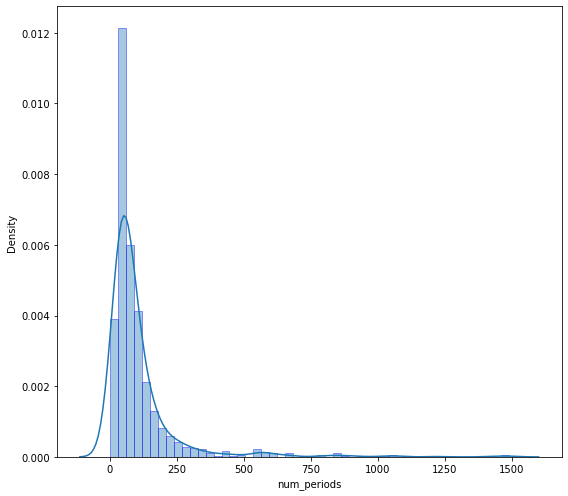

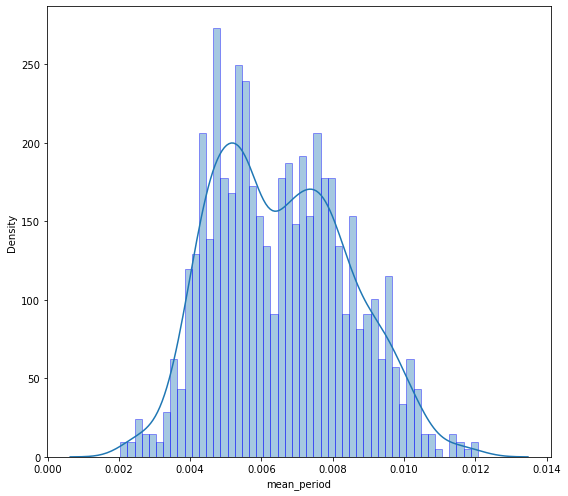

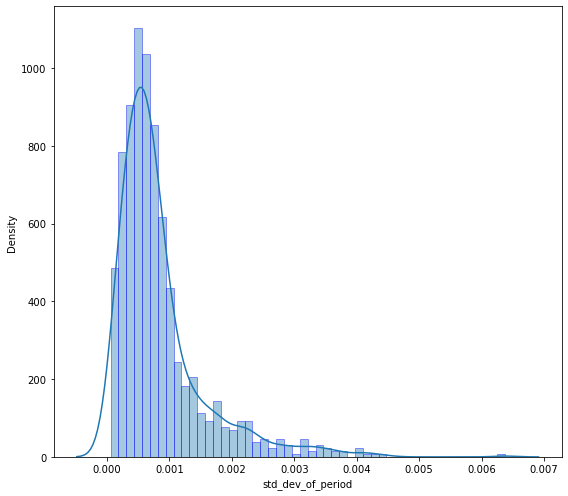

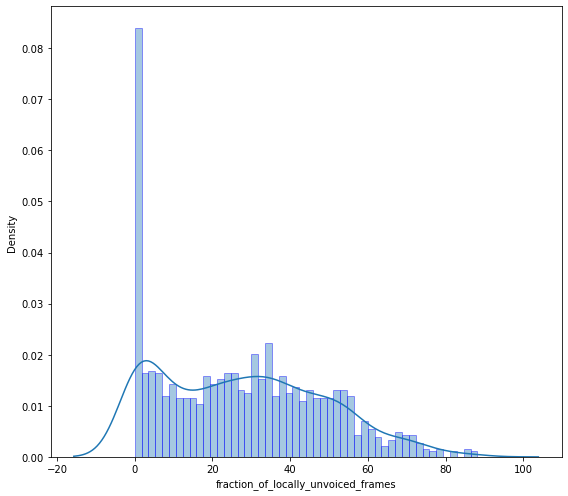

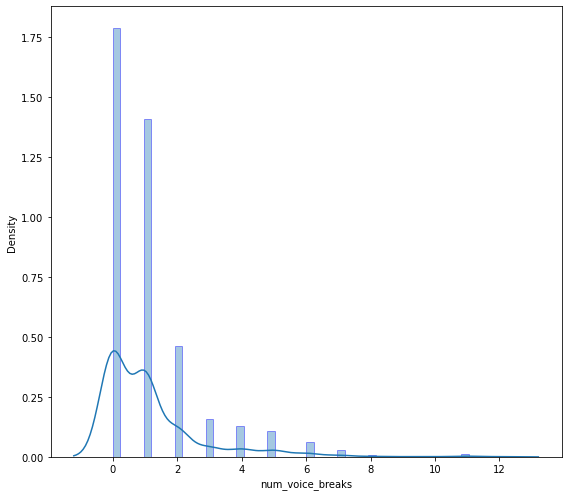

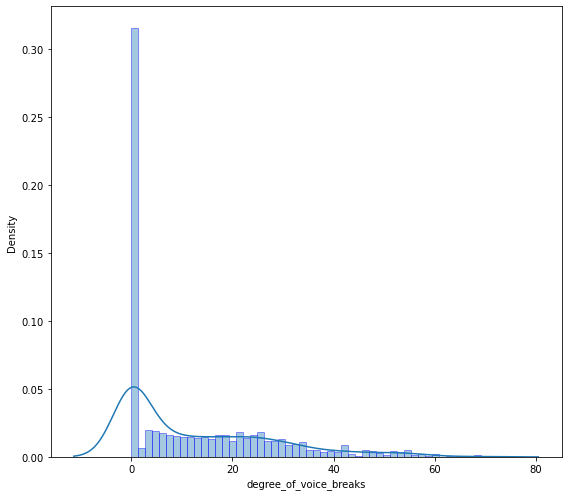

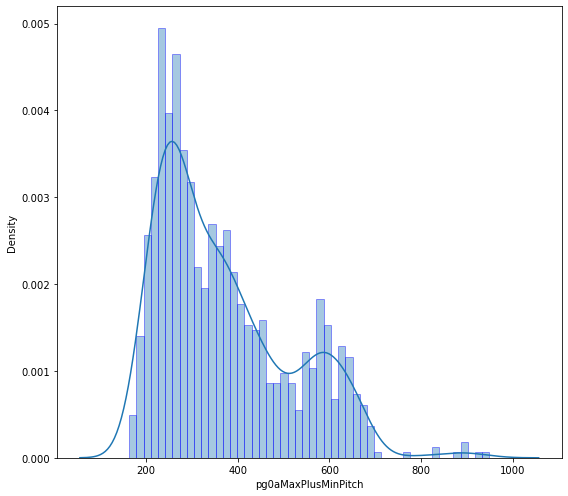

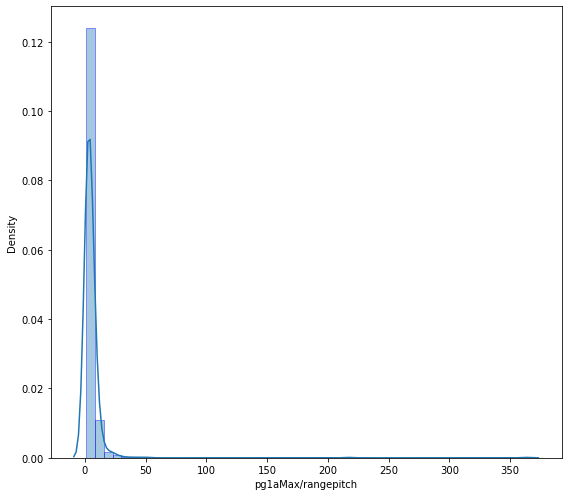

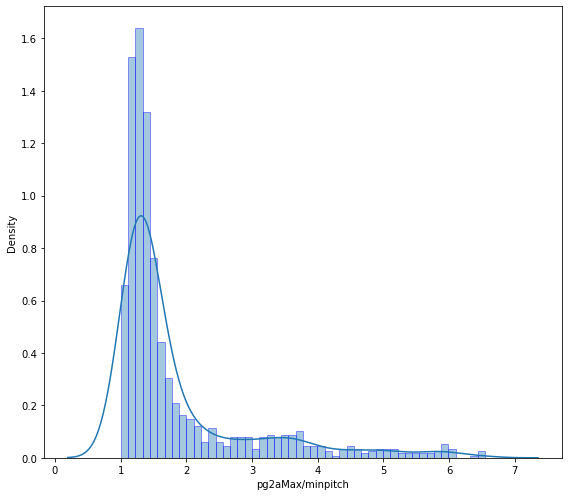

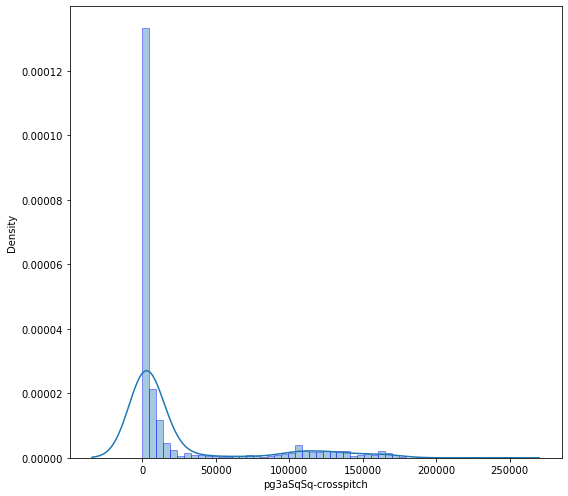

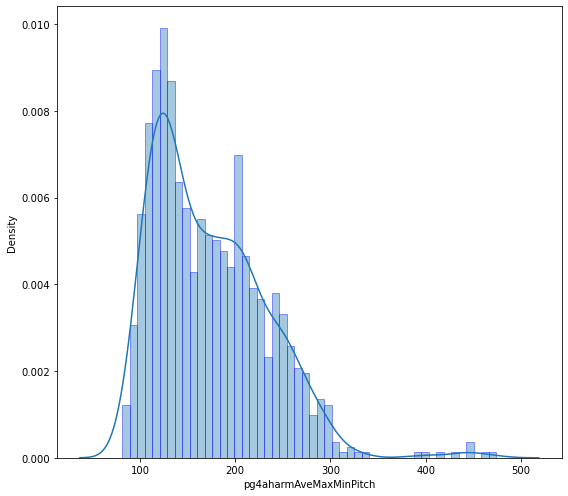

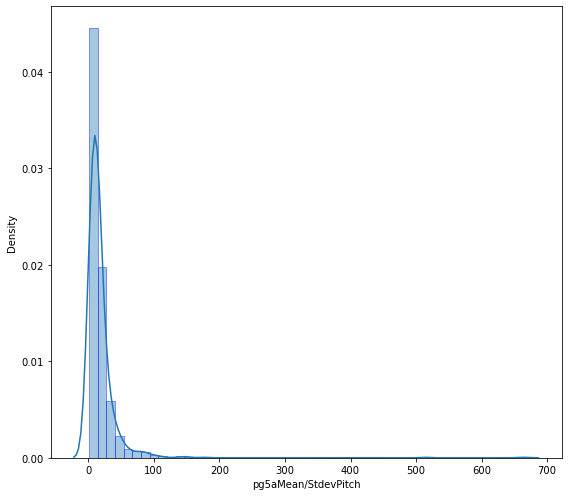

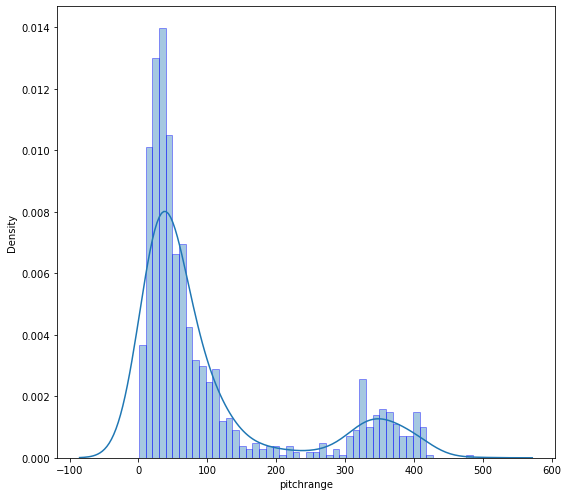

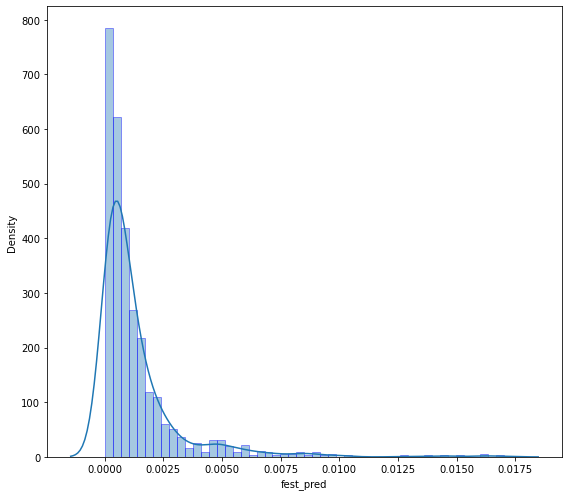

In [142]:
X = train_df.drop(['class_info', 'UPDRS', 'ID'], axis=1)
y = train_df['class_info']
target = 'class_info'
df = train_df

# plt.figure(figsize=(9, 5))
# col = 'jitter_local'
# sns.scatterplot(x=col, y=target, data=df).set_title('{} vs. {} EXAMPLE'.format(col, target))
# plt.ticklabel_format(style='plain')#style='plain', 'sci', 'scientific'

if verbose:
    for col in X.columns:
    #for col in ['jitter_local']:
        #scatter plots for each
        #plt.figure(figsize=(9, 5))
        #note that this plot is basically not helpful for binary categorization
        #sns.scatterplot(x=col, y=target, data=train_df).set_title('{} vs. {}'.format(col, target))
        #plt.ticklabel_format(style='plain')#style='plain', 'sci', 'scientific'

    #     fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    #     axes[0].set_title('{} Count'.format(col))
    #     sns.countplot(df[col], ax=axes[0], color='purple')
    #     axes[1].set_title('{} vs. {}'.format(col, target))
    #     sns.boxplot(x=col, y=target, data=df, ax=axes[1])

        plt.figure(figsize=(8, 7))
        sns.distplot(train_df[col], bins=50, hist_kws=dict(edgecolor="blue", linewidth=1))
        plt.ticklabel_format(style='plain')


        plt.tight_layout()

In [18]:
#if verbose:
display(y.value_counts())

1    520
0    520
Name: class_info, dtype: int64

## Boxplots of each predictor variable

,ID,jitter_local,jitter_local_abs,jitter_rap,jitter_ppq5,jitter_ddp,shimmer_local,shimmer_local_dB,shimmer_apq3,shimmer_apq5,...,max_pitch,num_pulses,num_periods,mean_period,std_dev_of_period,fraction_of_locally_unvoiced_frames,num_voice_breaks,degree_of_voice_breaks,UPDRS,class_info
0,1,1.488,0.000090,0.900,0.794,2.699,8.334,0.779,4.517,4.609,...,187.576,160,159,0.006065,0.000416,0.000,0,0.000,23,1
1,1,0.728,0.000038,0.353,0.376,1.059,5.864,0.642,2.058,3.180,...,234.505,170,169,0.005181,0.000403,2.247,0,0.000,23,1
2,1,1.220,0.000074,0.732,0.670,2.196,8.719,0.875,4.347,5.166,...,211.442,1431,1427,0.006071,0.000474,10.656,1,0.178,23,1
3,1,2.502,0.000123,1.156,1.634,3.469,13.513,1.273,5.263,8.771,...,220.230,94,92,0.004910,0.000320,0.000,0,0.000,23,1
4,1,3.509,0.000167,1.715,1.539,5.145,9.112,1.040,3.102,4.927,...,225.162,117,114,0.004757,0.000380,18.182,1,13.318,23,1


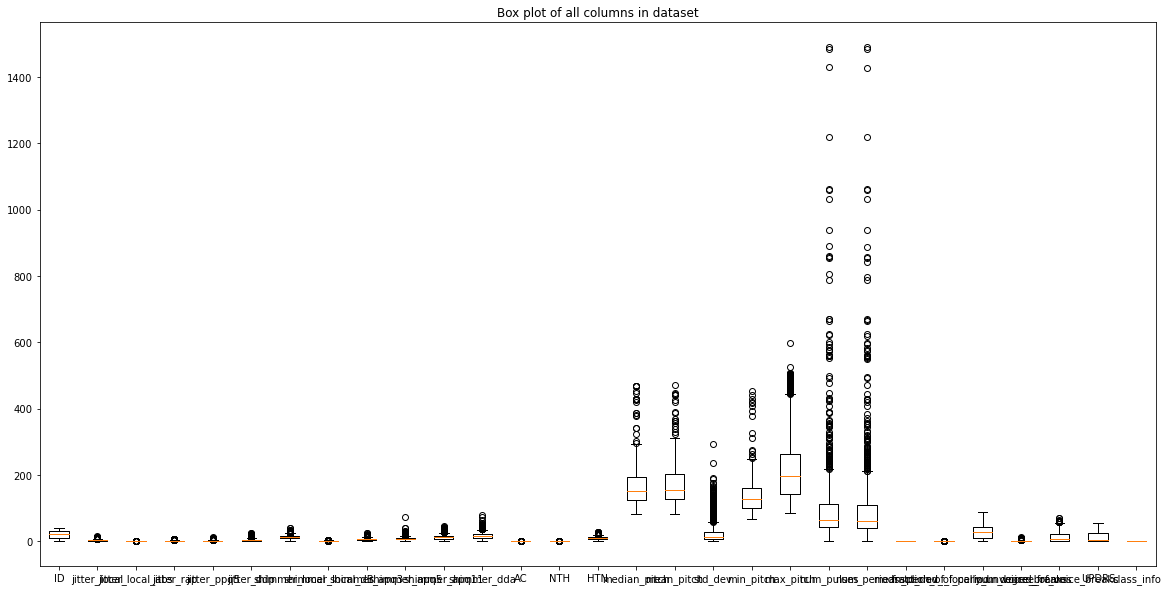

In [19]:
numcols = ['ID', 'jitter_local', 'jitter_local_abs', 'jitter_rap', 'jitter_ppq5',
       'jitter_ddp', 'shimmer_local', 'shimmer_local_dB', 'shimmer_apq3',
       'shimmer_apq5', 'shimmer_apq11', 'shimmer_dda', 'AC', 'NTH', 'HTN',
       'median_pitch', 'mean_pitch', 'std_dev', 'min_pitch', 'max_pitch',
       'num_pulses', 'num_periods', 'mean_period', 'std_dev_of_period',
       'fraction_of_locally_unvoiced_frames', 'num_voice_breaks',
       'degree_of_voice_breaks', 'UPDRS', 'class_info']
df_box = df[numcols]
display(df_box.head())
plt.figure(figsize=(20, 10))
#plt.xticks(rotation=45, ha='right')
plt.boxplot([df_box[col] for col in df_box.columns])
plt.title("Box plot of all columns in dataset")
plt.xticks(range(1, len(df_box.columns.values)+1), df_box.columns.values)
plt.show()

### Putting everything on the same scale here isn't so illuminating; let's split things up.

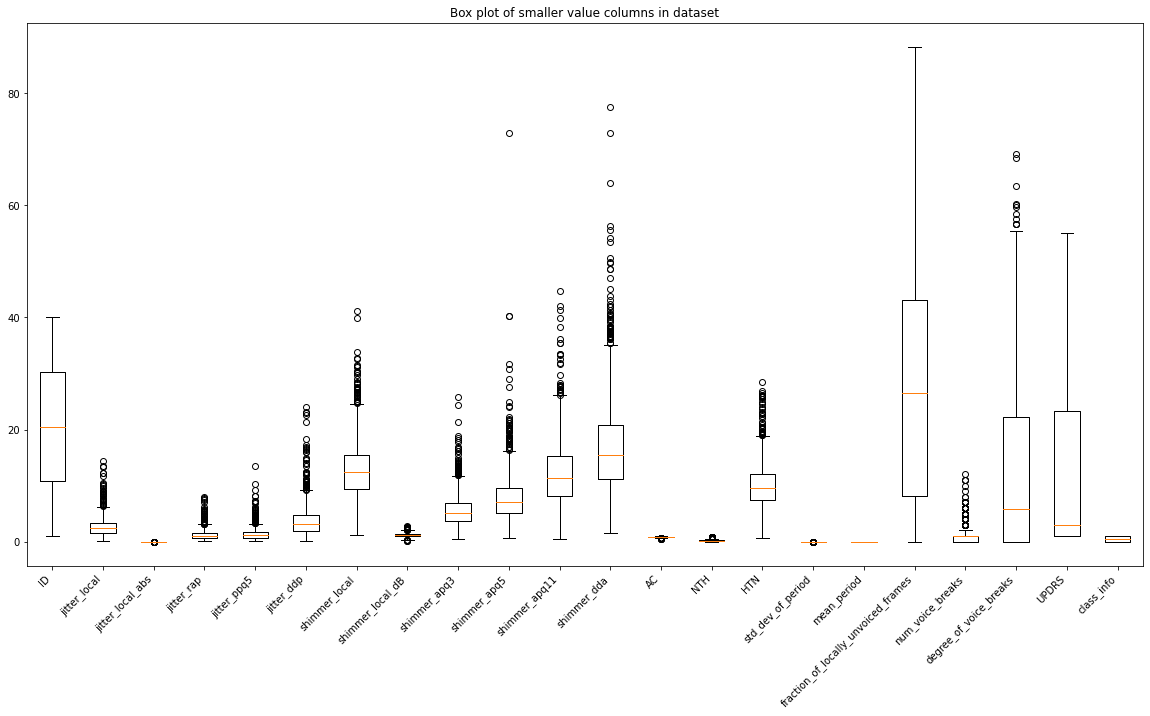

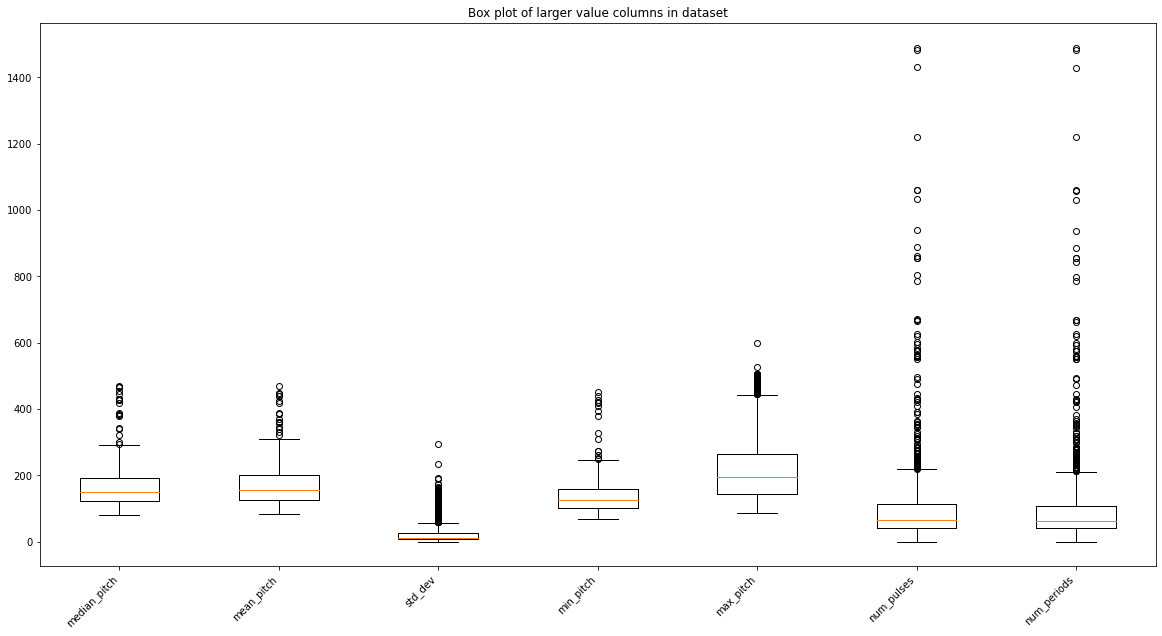

In [20]:
numcols1 = ['ID', 'jitter_local', 'jitter_local_abs', 'jitter_rap', 'jitter_ppq5',
       'jitter_ddp', 'shimmer_local', 'shimmer_local_dB', 'shimmer_apq3',
       'shimmer_apq5', 'shimmer_apq11', 'shimmer_dda', 'AC', 'NTH', 'HTN',
       'std_dev_of_period','mean_period',
       'fraction_of_locally_unvoiced_frames', 'num_voice_breaks',
       'degree_of_voice_breaks', 'UPDRS', 'class_info']
numcols2 = [ 'median_pitch', 'mean_pitch', 'std_dev', 'min_pitch', 'max_pitch',
       'num_pulses', 'num_periods', ]
df_box = df[numcols1]
#display(df_box.head())
plt.figure(figsize=(20, 10))
plt.xticks(rotation=45, ha='right')
plt.boxplot([df_box[col] for col in df_box.columns])
plt.title("Box plot of smaller value columns in dataset")
plt.xticks(range(1, 1+len(df_box.columns.values)), df_box.columns.values)
plt.show()

df_box = df[numcols2]
plt.figure(figsize=(20, 10))
plt.xticks(rotation=45, ha='right')
plt.boxplot([df_box[col] for col in df_box.columns])
plt.title("Box plot of larger value columns in dataset")
plt.xticks(range(1, 1+len(df_box.columns.values)), df_box.columns.values)
plt.show()

In [21]:
#A little deeper look at some of those with lots of outliers
display(df['fraction_of_locally_unvoiced_frames'].describe())
display(df['mean_period'].describe())
display(df['shimmer_dda'].describe())
display(df['num_pulses'].describe())
display(df['num_periods'].describe())

count    1040.000000
mean       27.682856
std        20.975294
min         0.000000
25%         8.149250
50%        26.501000
75%        43.064250
max        88.158000
Name: fraction_of_locally_unvoiced_frames, dtype: float64

count    1040.000000
mean        0.006547
std         0.001875
min         0.002039
25%         0.005039
50%         0.006484
75%         0.007923
max         0.012070
Name: mean_period, dtype: float64

count    1040.000000
mean       17.098839
std         9.045537
min         1.488000
25%        11.109500
50%        15.403000
75%        20.826000
max        77.459000
Name: shimmer_dda, dtype: float64

count    1040.000000
mean      109.744231
std       150.027703
min         0.000000
25%        42.750000
50%        65.000000
75%       113.000000
max      1490.000000
Name: num_pulses, dtype: float64

count    1040.000000
mean      105.969231
std       149.417074
min         0.000000
25%        40.750000
50%        62.000000
75%       109.000000
max      1489.000000
Name: num_periods, dtype: float64

Fraction of L.U.F. is a percentage, so ranges 0 to 100.  Just be careful about any possible log scaling on it.  The others just have substantial outlier variance.  Since we have enough other predictors, and our various tree and gradient methods should be able to ignore any problematic extra predictors, we will proceed as is for now.

# Initial Un-tuned Decision Tree Classifier, just to see some feature importances.

In [22]:
X = train_df.drop(['class_info', 'UPDRS', 'ID'], axis=1)
y = train_df['class_info']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=random_state_val)

### NB: the df_test data is still reserved for final testing

In [23]:
#A rather useful plotting function for feature importances for a model
def plot_feature_importances(model):
    '''plot feature importances for argument model, as long as model has .feature_importances_ defined.
    Examples would be decision tree or random forest models'''
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    
def zip_feature_importances(model, X):
    return sorted(zip(model.feature_importances_, X.columns.values))

Mean Cross Validation Score for DT: 65.13%
Fitted Score for DT training set:  1.0
Recall Score for DT test set:  0.5815602836879432


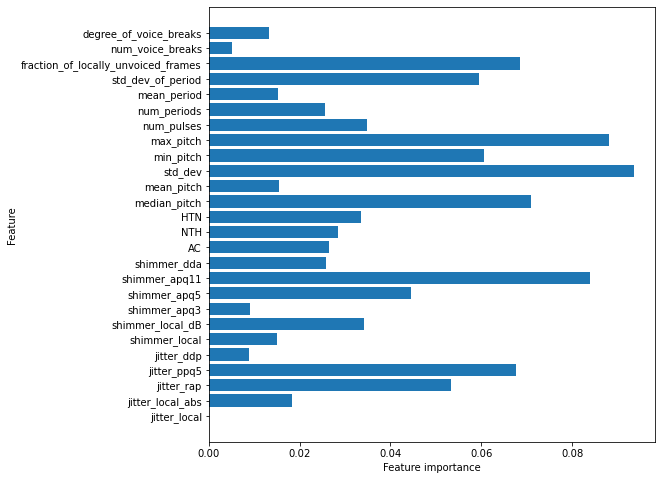

In [24]:
# Initial decision tree! 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier #come back for Adaboost?
from sklearn.metrics import accuracy_score

dt_clf = DecisionTreeClassifier(random_state=random_state_val)
scoring_p='recall' #or None
dt_cv_score = cross_val_score(dt_clf, X_train, y_train, cv=cv_def, scoring = scoring_p)
mean_dt_cv_score = np.mean(dt_cv_score)

print(f"Mean Cross Validation Score for DT: {mean_dt_cv_score :.2%}")

dt_clf.fit(X_train, y_train)
y_preds = dt_clf.predict(X_train)
print("Fitted Score for DT training set: ", recall(y_preds, y_train))
y_test_preds = dt_clf.predict(X_test)
print("Recall Score for DT test set: ", recall(y_test_preds, y_test))


#print(dt_clf.get_params())
#print(dt_clf.feature_importances_)

plot_feature_importances(dt_clf)
############################################################


# ---Feature Engineering---

# Repeated patient data leakage caveat
Initially in analysis, some features I engineered took into account the max/min across ID values.  This gave very good results!  However, I then realized that there was effectively data leakage within the cross-validation process, since some lines for a given ID (even when dropping the ID column itself) would be used for training and then again in validation.  This repeated data is inherently troublesome because of the possibility to overfit for these repeated patients.  

Strategies to address this: 
1) manually reserve some percentage of ID values to use as a validation set.  
2) avoid doing any feature engineering that groups by ID value.  
While 1 is attractive, it's probably a better long-term approach to use 2.  In part, this would be more realistic in practice, since a diagnostic test would be more easily administered with just one battery of voice samples, not repeating the same test multiple times.  

Another approach would be to do -both-.  This could be the focus of a later analysis.

# Gender/Sex features    
From our data, "The data collected in the context of this study (Fig. 1) belongs to 20 PWP (6 female, 14 male) and 20 healthy individuals (10 female, 10 male) who appealed at the Department of Neurologyin Cerrahpas¸a Faculty of Medicine, Istanbul University."
Reports (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2117736/) state that PD is 1.5-2 times more common in males than females, so this could be an important feature to acquire.  Biological sex is, however, separate from gender expression (which voice pitch would be more indicative of).  Ethically, we'd strive to achieve equity in engineering features and modelling, while making a model that was optimally accurate for health outcomes.  

Since there appears to be bi-modality in pitch distributions, this indicates gender predictability; 
but some overlap in pitch curves, we will try to engineer a few more discerning features.  
Max pitch does seem to have the most disjoint distribution, we can use that as a starting point.

Initially, I thought to make a binary feature for this, by calculating a number, then comparing it against a mean threshold value; but on later reflection, decided to leave the numerical feature and let the models optimize whatever predictive power these features have.

In [25]:
train_df[['max_pitch', 'min_pitch']].describe()
#train_ID_grp['max_pitch'].max()

,max_pitch,min_pitch
count,1040.000000,1040.000000
mean,234.875990,134.538101
std,121.541243,47.058058
min,85.541000,67.957000
25%,143.650750,100.852250
50%,195.971000,127.277000
75%,263.798250,159.664750
max,597.974000,452.083000


In [26]:
#Initial approach, not used, grouping by ID then using aggregation functions

##I Would delete this cell ideally; however, leaving it here for reference/discussion.  This method, by taking max/min values
#across repeated ID values, instituted data leakage!  Beware!

## Try 1 - the problem was that it grouped by ID
# train_ID_grp = train_df.copy().groupby('ID')

# max_pitch_thresh = 495
# train_df['pg0a_MaxMaxpitch'] = train_ID_grp['max_pitch'].transform('max')
# #display(train_df[['ID', 'pred_gend0']])
# #temp_df = pd.merge(train_df, train_ID_grp['max_pitch'].max(), how='left')#, suffixes=(None, '_max'))
# display(train_ID_grp['max_pitch'].max().head())
# #display(temp_df.head())
# #display(temp_df.columns)
# #display(temp_df.max_pitch)
# train_df['pg0b'] = (train_ID_grp['max_pitch'].transform('max') > max_pitch_thresh).apply(lambda x: 'F' if x else 'M')

# thresh1 = 1.3
# train_df['pg1aMax/rangepitch'] = (train_ID_grp['max_pitch'].transform('max')/(train_ID_grp['max_pitch'].transform('max')-train_ID_grp['min_pitch'].transform('min')))
# train_df['pg1b'] = (train_ID_grp['max_pitch'].transform('max')/(train_ID_grp['max_pitch'].transform('max')-train_ID_grp['min_pitch'].transform('min'))>thresh1).apply(lambda x: 'F' if x else 'M')

# thresh2 = 5.7
# train_df['pg2aMax/minpitch'] = ((train_ID_grp['max_pitch'].transform('max')/(train_ID_grp['min_pitch'].transform('min'))))
# train_df['pg2b'] = ((train_ID_grp['max_pitch'].transform('max')/(train_ID_grp['min_pitch'].transform('min'))>thresh2)).apply(lambda x: 'F' if x else 'M')

# thresh3 = 155000
# train_df['pg3aSqSq-crosspitch'] = (train_ID_grp['max_pitch'].transform('max')**2 + train_ID_grp['min_pitch'].transform('min') **2 -2*train_ID_grp['max_pitch'].transform('max')*train_ID_grp['min_pitch'].transform('min'))
# train_df['pg3b'] = (train_ID_grp['max_pitch'].transform('max')**2 + train_ID_grp['min_pitch'].transform('min') **2 -2*train_ID_grp['max_pitch'].transform('max')*train_ID_grp['min_pitch'].transform('min') > thresh3).apply(lambda x: 'F' if x else 'M')

# thresh4 = 200
# train_df['pg4aharmAveMaxMinPitch'] = ((train_ID_grp['max_pitch'].transform('max')*(train_ID_grp['min_pitch'].transform('min')))**(1/2) )
# train_df['pg4b'] = ((train_ID_grp['max_pitch'].transform('max')*(train_ID_grp['min_pitch'].transform('min')))**(1/2) > thresh4).apply(lambda x: 'F' if x else 'M')

# thresh5 = 183
# train_df['pg5aMeanMeanPitch'] = train_ID_grp['mean_pitch'].transform('mean')
# train_df['pg5b'] = (train_ID_grp['mean_pitch'].transform('mean') > thresh5).apply(lambda x: 'F' if x else 'M')

# #train_df['pred_gender0']O
# gencols = ['pg0a_MaxMaxpitch', 'pg1aMax/rangepitch', 'pg2aMax/minpitch', 'pg3aSqSq-crosspitch', 'pg4aharmAveMaxMinPitch',
#            'pg5aMeanMeanPitch']
# gencolsb = ['pg0b', 'pg1b', 'pg2b', 'pg3b', 'pg4b', 'pg5b']
# #train_df['pred_gender0'].value_counts()/40
# train_df.columns
# #train_df['pred_gend0']
# #(train_ID_grp['max_pitch'].max())

In [27]:
# for col in gencolsb:
#     display(train_df[col].value_counts()/26, train_df[col].value_counts().sum()/26)
#     #display(train_df[col].isna().sum())

In [28]:
#Subsequent approach, reexamining those features just for each row in dataset.
#train_ID_grp = train_df.copy().groupby('ID')

train_df['pg0aMaxPlusMinPitch'] = train_df['max_pitch'] + train_df['min_pitch']
#this potentially could be different than 2*mean, based on amount of time spent on those pitches

train_df['pg1aMax/rangepitch'] = (train_df['max_pitch']/(train_df['max_pitch']-train_df['min_pitch']))

train_df['pg2aMax/minpitch'] = ((train_df['max_pitch']/(train_df['min_pitch'])))

train_df['pg3aSqSq-crosspitch'] = (train_df['max_pitch']**2 + train_df['min_pitch'] **2 -2*train_df['max_pitch']*train_df['min_pitch'])

train_df['pg4aharmAveMaxMinPitch'] = ((train_df['max_pitch']*(train_df['min_pitch']))**(1/2) )

train_df['pg5aMean/StdevPitch'] = train_df['mean_pitch']/train_df['std_dev']

#train_df['pred_gender0']O
gencols = ['pg0aMaxPlusMinPitch', 'pg1aMax/rangepitch', 'pg2aMax/minpitch', 'pg3aSqSq-crosspitch', 'pg4aharmAveMaxMinPitch',
           'pg5aMean/StdevPitch']
#train_df['pred_gender0'].value_counts()/40
train_df.columns
#train_df['pred_gend0']
#(train_ID_grp['max_pitch'].max())

Index(['ID', 'jitter_local', 'jitter_local_abs', 'jitter_rap', 'jitter_ppq5',
       'jitter_ddp', 'shimmer_local', 'shimmer_local_dB', 'shimmer_apq3',
       'shimmer_apq5', 'shimmer_apq11', 'shimmer_dda', 'AC', 'NTH', 'HTN',
       'median_pitch', 'mean_pitch', 'std_dev', 'min_pitch', 'max_pitch',
       'num_pulses', 'num_periods', 'mean_period', 'std_dev_of_period',
       'fraction_of_locally_unvoiced_frames', 'num_voice_breaks',
       'degree_of_voice_breaks', 'UPDRS', 'class_info', 'pg0aMaxPlusMinPitch',
       'pg1aMax/rangepitch', 'pg2aMax/minpitch', 'pg3aSqSq-crosspitch',
       'pg4aharmAveMaxMinPitch', 'pg5aMean/StdevPitch'],
      dtype='object')

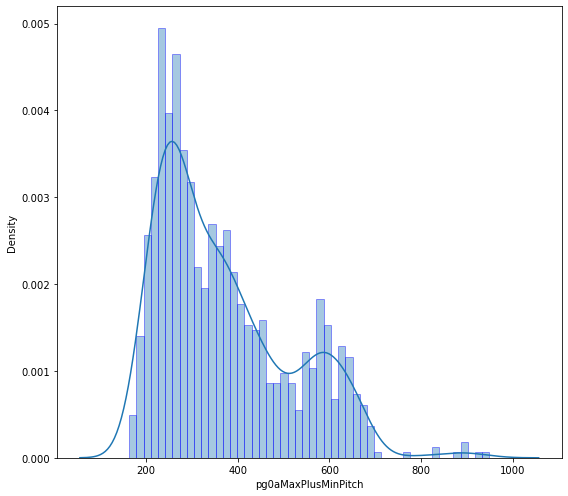

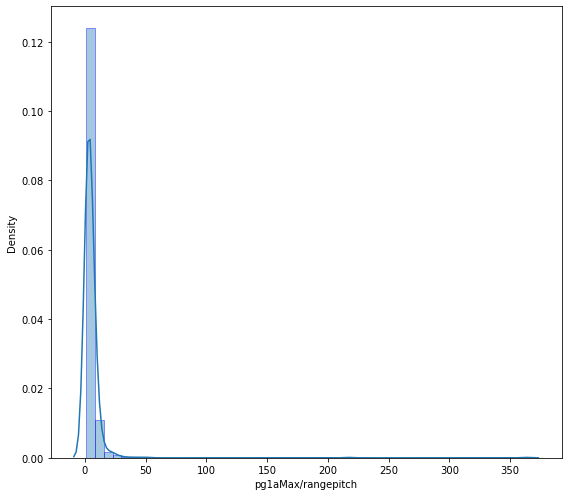

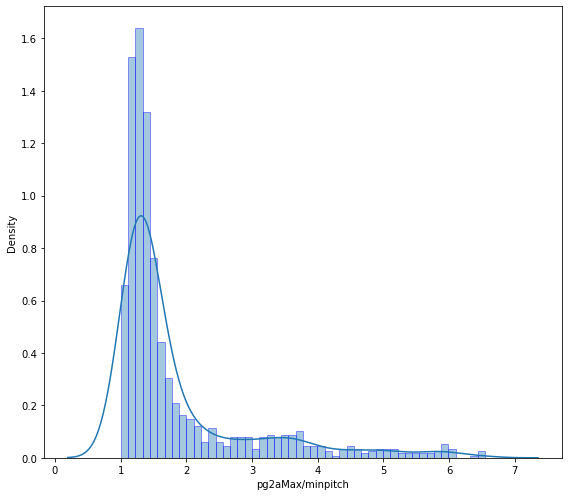

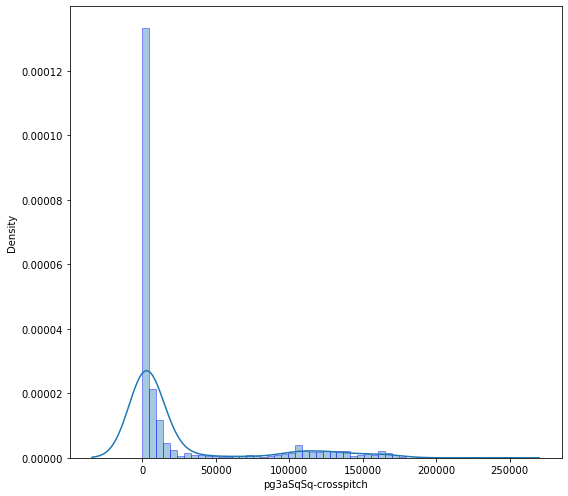

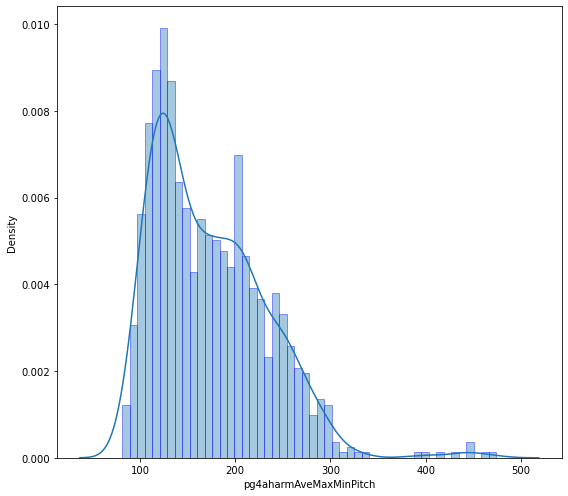

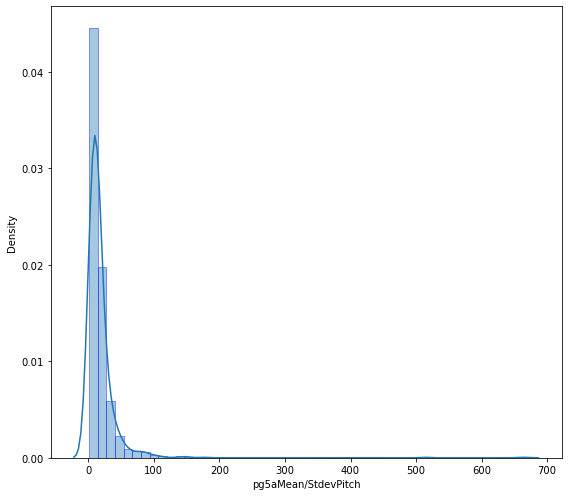

In [29]:
for col in gencols:
    plt.figure(figsize=(8, 7))
    sns.distplot(train_df[col], bins=50, hist_kws=dict(edgecolor="blue", linewidth=1))
    plt.ticklabel_format(style='plain')
    

    plt.tight_layout()

So, depending on these threshold choices, we can make some adequate divisions of genders; we will leave it to the various models to see how useful these are for predicting PD.  
We could set thresholds, then cross validate to see if these threshold choices are any good, but really, the threshold choices are immaterial, the original engineered feature is more important.

# Monotonicity check  
One characteristic of PD is a monotone voice - we can make another pitch feature to check total pitch range.

In [30]:
train_df['pitchrange'] = train_df['max_pitch']-train_df['min_pitch']
train_df['pitchrange'].describe()

count    1040.000000
mean      100.337889
std       115.203172
min         0.754000
25%        28.998500
50%        49.463500
75%       106.686750
max       485.677000
Name: pitchrange, dtype: float64

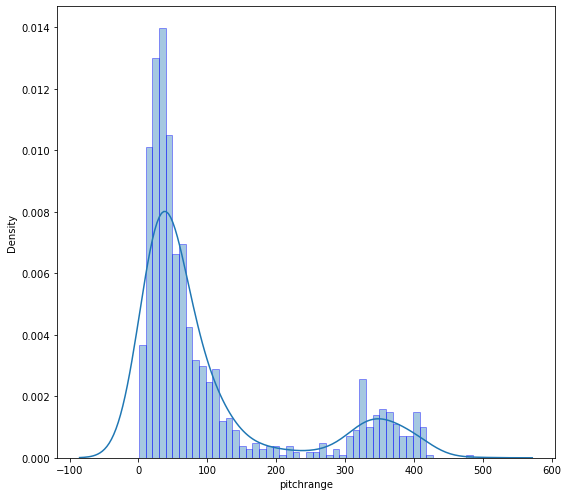

In [31]:
plt.figure(figsize=(8, 7))
sns.distplot(train_df['pitchrange'], bins=50, hist_kws=dict(edgecolor="blue", linewidth=1))
plt.ticklabel_format(style='plain')
plt.tight_layout()

#This looks to have some bimodality which we're looking for in this feature; though it seems to under-categorize the 
#higher range population

# Oral Festination feature

As mentioned above:
"In Parkinson's disease (PD), festination corresponds to a tendency to speed up when performing repetitive movements. First described in gait (and then in handwriting and speech), festination is one of the most disabling axial symptoms" - https://pubmed.ncbi.nlm.nih.gov/17516477/

I attempt to describe oral festination using the existing features in the following way: the product of period_standard_deviation and jitter_ppq5.  


In [32]:
train_df['fest_pred'] = train_df['jitter_ppq5']*train_df['std_dev_of_period']
train_df['fest_pred'].describe()

count    1040.000000
mean        0.001343
std         0.001935
min         0.000005
25%         0.000319
50%         0.000743
75%         0.001531
max         0.017029
Name: fest_pred, dtype: float64

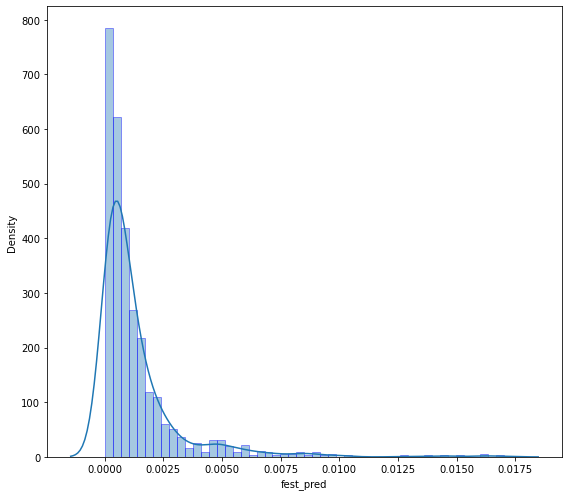

In [33]:
plt.figure(figsize=(8, 7))
sns.distplot(train_df['fest_pred'], bins=50, hist_kws=dict(edgecolor="blue", linewidth=1))
plt.ticklabel_format(style='plain')
plt.tight_layout()
#this doesn't appear to have great separation power at this point - though perhaps our models will be able to make more of it.

In [34]:
# make function for later use (uniformity on the test_df and pipelines)
def pred_eng_feat(df):
    '''creates the aforementioned engineered feature columns, given a dataframe'''
    df['pg0aMaxPlusMinPitch'] = df['max_pitch'] + df['min_pitch']
    #this potentially could be different than 2*mean, based on amount of time spent on those pitches

    df['pg1aMax/rangepitch'] = (df['max_pitch']/(df['max_pitch']-df['min_pitch']))

    df['pg2aMax/minpitch'] = ((df['max_pitch']/(df['min_pitch'])))

    df['pg3aSqSq-crosspitch'] = (df['max_pitch']**2 + df['min_pitch'] **2 -2*df['max_pitch']*df['min_pitch'])

    df['pg4aharmAveMaxMinPitch'] = ((df['max_pitch']*(df['min_pitch']))**(1/2) )

    df['pg5aMean/StdevPitch'] = df['mean_pitch']/df['std_dev']
    
    df['pitchrange'] = df['max_pitch']-df['min_pitch']
    
    df['fest_pred'] = df['jitter_ppq5']*df['std_dev_of_period']
    
    #train_df['pred_eng_feater0']O
    #gencols = ['pg0a', 'pg1a', 'pg2a', 'pg3a', 'pg4a']
    return df



# Train Test Split!

In [35]:
X = train_df.drop(['class_info', 'UPDRS', 'ID'], axis=1)
y = train_df['class_info']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=random_state_val)

### Now, including engineered features and train/test split, let's look at a correlation heatmap

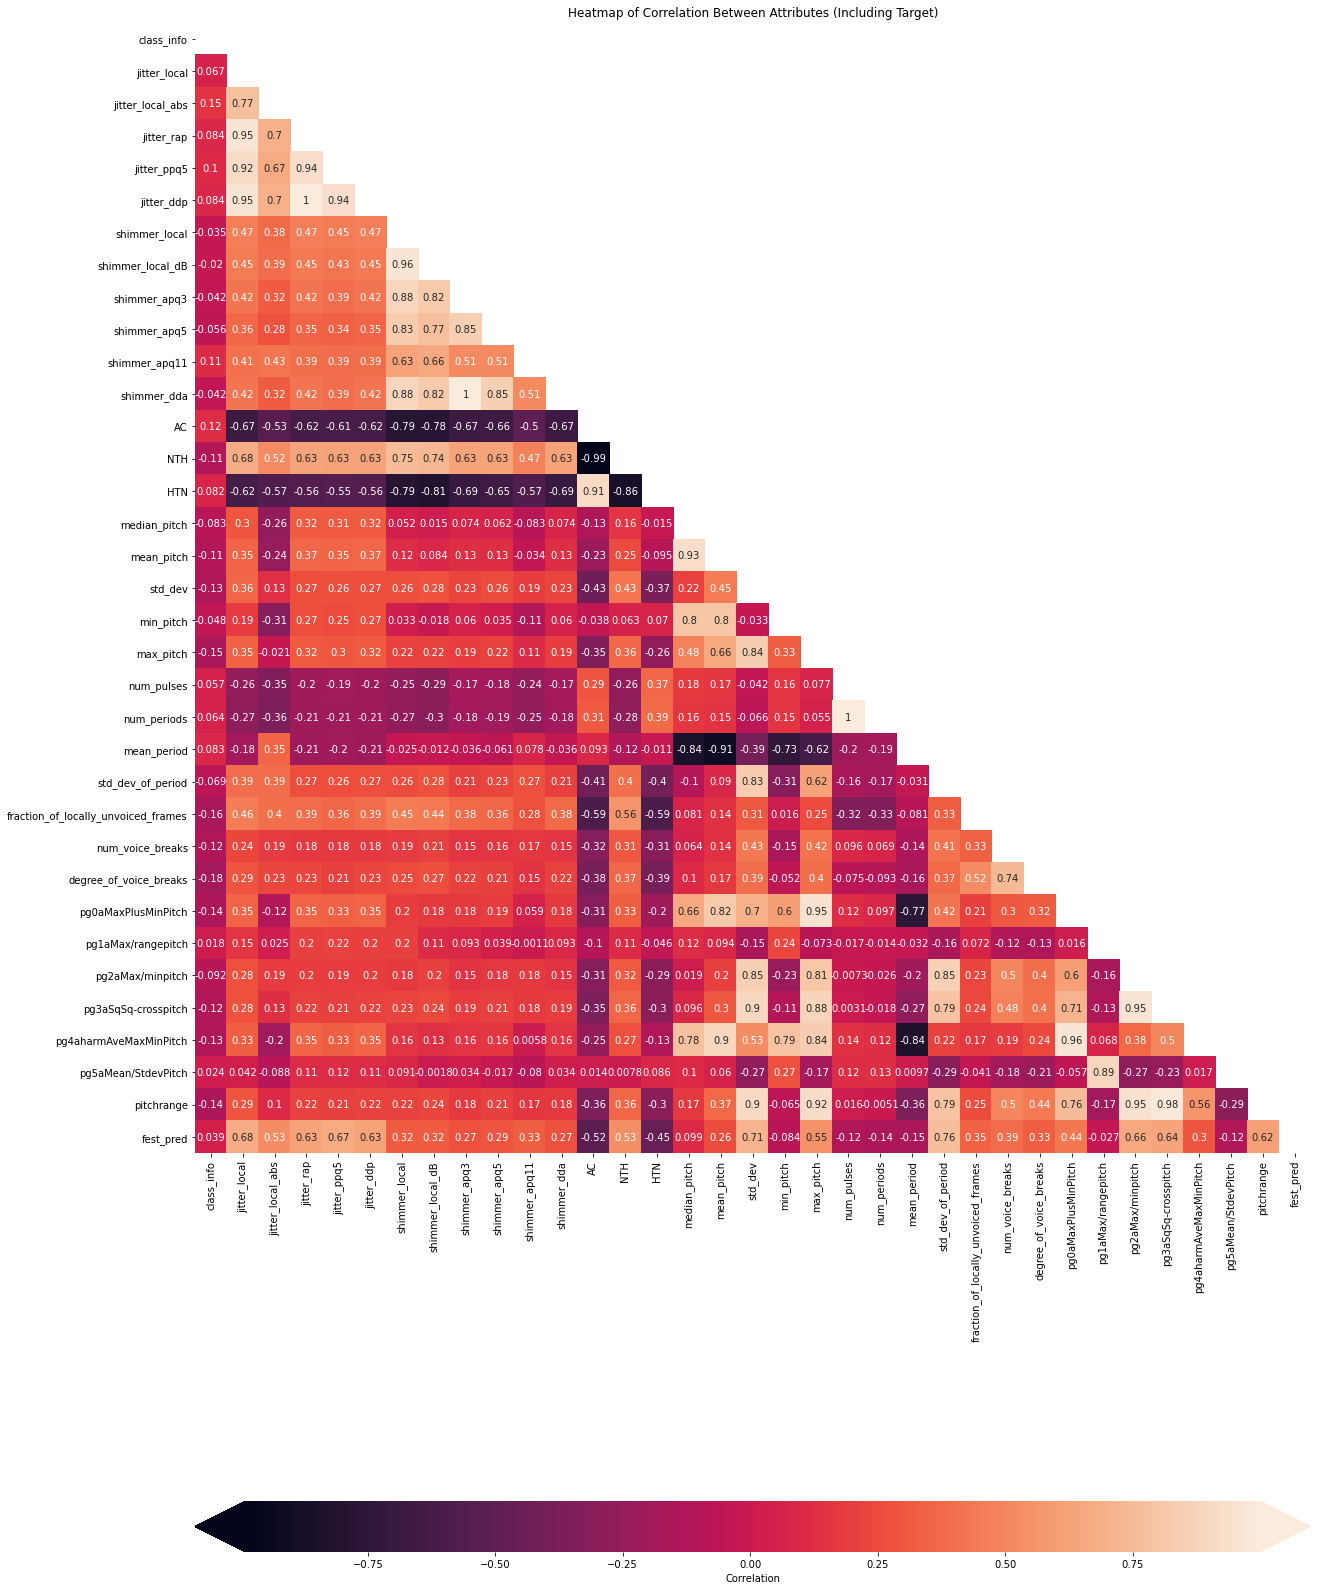

In [36]:
heatmap_data = pd.concat([y_train, X_train], axis=1)
corr = heatmap_data.corr()

fig, ax = plt.subplots(figsize=(20, 32))

# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

So far, Class_info has correlation of highest magnitude with jitter_local_abs, shimmer_apq11, AC, NTH, mean_pitch, std_dev(of pitch), max_pitch, fraction_of_locally_unvoiced_frames, num_voice_breaks, and degree_of_voice_breaks.  These all seem very descriptive with lowest "evenness" and consistency (and therefore control) of voice.  
Curiously, three of the projected gender columns as well as pitch_range also have good predictive potential. 

In [37]:
# checking in on number of predictors in X_train, to keep consistent with later
if verbose:
    print(len(X_train.columns))
    X_train.columns


# Defining a scaler  
Since many of our columns had very different ranges, let's uniformly scale the data.

In [38]:
#First, let's make some scaled X data, given we were noticing a wide discrepancy of ranges on those.
# Import StandardScaler
from sklearn.preprocessing import StandardScaler 

# Instantiate StandardScaler
scaler = StandardScaler()

# Transform the training and test sets
scaled_data_train = scaler.fit_transform(X_train)
scaled_data_test = scaler.transform(X_test)

# Convert into a DataFrame
scaled_df_train = pd.DataFrame(scaled_data_train, columns=X_train.columns)
scaled_df_train.head()

,jitter_local,jitter_local_abs,jitter_rap,jitter_ppq5,jitter_ddp,shimmer_local,shimmer_local_dB,shimmer_apq3,shimmer_apq5,shimmer_apq11,...,num_voice_breaks,degree_of_voice_breaks,pg0aMaxPlusMinPitch,pg1aMax/rangepitch,pg2aMax/minpitch,pg3aSqSq-crosspitch,pg4aharmAveMaxMinPitch,pg5aMean/StdevPitch,pitchrange,fest_pred
0,-0.517371,-0.288836,-0.309006,-0.521692,-0.309345,-0.679655,-0.680858,-0.552115,-0.596805,-0.381602,...,-0.688821,-0.785367,-0.812277,0.418817,-0.685594,-0.515482,-0.783242,0.578809,-0.771902,-0.602496
1,-0.898027,-1.063577,-0.832523,-0.808353,-0.832848,-0.888508,-1.102410,-0.462594,-0.724695,-0.706292,...,-0.688821,-0.785367,-0.142491,0.086539,-0.612198,-0.501577,0.018031,0.093410,-0.629008,-0.640375
2,0.169268,1.187298,0.272007,-0.120551,0.272325,-0.607523,-0.573075,-0.489383,-0.553130,-0.714480,...,-0.086489,0.724548,-1.084764,-0.095039,-0.463907,-0.498401,-1.128138,-0.091503,-0.607274,-0.251018
3,-0.706015,-1.014336,-0.645913,-0.664565,-0.645571,-0.578817,-0.525171,-0.542959,-0.521158,-0.311083,...,-0.688821,-0.785367,0.361264,-0.198498,-0.102758,-0.239621,0.506809,-0.163322,0.104526,-0.575377
4,0.675125,0.407909,0.582688,0.553514,0.582997,-0.303904,-0.309605,-0.282535,-0.241764,-0.334143,...,-0.086489,0.140342,-0.236541,-0.197677,-0.108976,-0.345935,-0.186545,-0.305498,-0.102656,0.138246


# Some initial logistic regression exploration (and first foray into Pipeline)

In [39]:
#at the risk of overfitting, we can investigate the results if we OneHotEncode everything - yes, this is probably a bad idea
#because we have numerical data, not categorical.
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    OneHotEncoder(categories='auto'),
    LogisticRegression(solver='lbfgs', multi_class='ovr',
                      max_iter=500))
pipe.fit(scaled_data_train,y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder()),
                ('logisticregression',
                 LogisticRegression(max_iter=500, multi_class='ovr'))])

In [40]:
from sklearn.metrics import accuracy_score

# What's the accuracy of this prediction, measured against the training dataset?
y_pred = pipe.predict(scaled_data_train)
display(accuracy_score(y_train, y_pred))
#display()
score_suite(y_train, y_pred)

1.0

[['precision', 'recall', 'accuracy', 'f1_score', 'mcc'],
 [1.0, 1.0, 1.0, 1.0, 1.0]]

In [41]:
#Pipeline uses onehot encoding on EVERYTHING, so it misses some numerical values in the test set
# test_X = test_df.drop(['class_info', 'ID'], axis=1)
# len(test_X.columns)
# test_X.columns
# y_test_pred = pipe.predict(test_X)
# accuracy_score(test_df['class_info'], y_test_pred)

This is great results on the training set, but certainly overfit.  If we try to pipeline the test set through, we miss values (because we had numerical data, not categorical!)  


Instead, let's use a logistic regression without onehotencoding.

In [42]:
logreg = LogisticRegression(solver='lbfgs', multi_class='ovr',
                      max_iter=500, random_state=random_state_val)
logreg.fit(scaled_data_train, y_train)
y_pred = logreg.predict(scaled_data_train)
display(accuracy_score(y_train, y_pred))
display(score_suite(y_train, y_pred))
y_test_pred = logreg.predict(scaled_data_test)
display(score_suite(y_test, y_test_pred))

0.6833333333333333

[['precision', 'recall', 'accuracy', 'f1_score', 'mcc'],
 [0.6721698113207547,
  0.7251908396946565,
  0.6833333333333333,
  0.6976744186046511,
  0.36740573708740043]]

[['precision', 'recall', 'accuracy', 'f1_score', 'mcc'],
 [0.6056338028169014,
  0.6771653543307087,
  0.6269230769230769,
  0.6394052044609666,
  0.2571423794471028]]

This recall of 72.5% on the training set is not bad; it falls to 67% on the test set.  
On cross validation (see below) we run about 70%.

In [43]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
score = np.mean(cross_val_score(logreg, scaled_data_train, y_train, cv=cv_def, scoring=scoring_p))#'neg_mean_squared_error'))#scoring='neg_mean_squared_error' / 'r2'
display(score)
logregmeanscore = score
logregscore = cross_val_score(logreg, X_train, y_train, cv=cv_def, scoring=scoring_p)
logregscore

0.6895813047711781

array([0.71794872, 0.67948718, 0.6835443 , 0.67088608, 0.62025316])

Let's look at feature importances on the logistic regression

In [44]:
sorted(zip(logreg.coef_[0], X_train.columns))

[(-0.5191045623410737, 'mean_period'),
 (-0.4301884593392494, 'pitchrange'),
 (-0.396892836520483, 'pg4aharmAveMaxMinPitch'),
 (-0.31907567235768675, 'std_dev_of_period'),
 (-0.26765898779859504, 'max_pitch'),
 (-0.22490257986535545, 'fraction_of_locally_unvoiced_frames'),
 (-0.209600604982922, 'degree_of_voice_breaks'),
 (-0.2020588580239283, 'std_dev'),
 (-0.16618527547515533, 'pg5aMean/StdevPitch'),
 (-0.16058013189131354, 'jitter_ddp'),
 (-0.15958107605986652, 'jitter_rap'),
 (-0.15711684129494582, 'shimmer_apq5'),
 (-0.13033040829512677, 'num_pulses'),
 (-0.12127640444709935, 'median_pitch'),
 (-0.10797762066670623, 'pg0aMaxPlusMinPitch'),
 (-0.09907184472217509, 'num_voice_breaks'),
 (-0.04139890373505034, 'shimmer_local'),
 (-0.0405098585989916, 'shimmer_dda'),
 (-0.039251872682010094, 'shimmer_apq3'),
 (-0.02354046428416598, 'jitter_local'),
 (-0.003200233054483874, 'HTN'),
 (-0.0007095261493496484, 'NTH'),
 (0.09869933518252105, 'mean_pitch'),
 (0.11699341424710137, 'pg1aMax/r

Degree of voice breaks and fraction of locally unvoiced frames here seems very surprising to have inverse correlation with PD.  There are outliers here that likely skew the data, especially since most of the degree_of_voice_breaks values are near 0.  
Optimistically, we will find a model that drops out certain features that fits better.  

Shimmer_apq11 is again one of the stronger predictors, but we also see jitter_local_abs, AC, and our engineered features pg3 and fest_pred appearing.

In [45]:
#let's quickly check out what results would be on the reserved test set
#test_df
test_df_scaled = scaler.transform(pred_eng_feat(test_df.drop(['class_info', 'ID'], axis=1)))
y_test_pred = logreg.predict(test_df_scaled)
#accuracy_score(test_df['class_info'], y_test_pred)
score_suite(test_df['class_info'], y_test_pred)

[['precision', 'recall', 'accuracy', 'f1_score', 'mcc'],
 [1.0, 0.3273809523809524, 0.3273809523809524, 0.4932735426008969, nan]]

Logistic regression doesn't do remarkably well for the test set (which, by the way, is entirely PWP).

# K-Nearest Neighbors  
Let's try a KNN model, and investigate it manually (NB: technically we are using the train/test split's test set here to optimize a hyperparameter k - which is not ideal - so we we wouldn't employ this technique for validation, just in this case for gaining perspective).
Once we've taken a look at that, let's use GridSearchCV.

Now we can proceed with KNN investigation using both scaled and non-scaled data.

In [46]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
#kn

##fit KNN model
# Import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

# Instantiate KNeighborsClassifier
clf = KNeighborsClassifier()

# Fit the classifier
clf.fit(scaled_data_train, y_train)
print('params:', clf.get_params())

# Predict on the test set
test_preds = clf.predict(scaled_data_test)

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
# Complete the function
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))
    print("MCC Score: {}".format(mcc(labels, preds)))
    
print("---Metrics for Initial KNN on test set (No CV or param search)---")
print_metrics(y_test, test_preds)

#labels = y_train#train_df['class_info']
#train_df['class_info'].value_counts()
#display("Naively guessing PD all the time would give us:", labels.value_counts(normalize=True))
#note that just by naively guessing 1 all the time, we'd get accuracy of 50% on the train set and 100% on the test set

##improve model perf - search for better k

def find_best_k(X_train, y_train, X_test, y_test, scoremetric, min_k=1, max_k=25):
    '''iterates through kvalues, trains on train set, returns optimal k value for test set
    WARNING - this technique uses the test set in order to find and optimize the hyperparameter k.  '''
    best_k = 0
    best_score = 0.0
    if min_k % 2==0:
        min_k+=1
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        newscore = eval(scoremetric+'(y_test, preds)')
        if newscore > best_score:
            best_k = k
            best_score = newscore
    print("\n---Metrics for Parameter-searched KNN, without CrossValidation---")
    print('(using {} as optimization metric)'.format(scoremetric))
    print("Best Value for k: {}".format(best_k))
    #print("{}-Score: {}".format(scoremetric, best_score))
    test_preds = KNeighborsClassifier(n_neighbors=best_k).fit(X_train, y_train).predict(X_test)
    train_preds = KNeighborsClassifier(n_neighbors=best_k).fit(X_train, y_train).predict(X_train)
    print("\nTrain set metrics:")
    print_metrics(y_train, train_preds)
    print("\nTest set metrics:")
    print_metrics(y_test, test_preds)

find_best_k(scaled_data_train, y_train, scaled_data_test, y_test, 'recall')



params: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
---Metrics for Initial KNN on test set (No CV or param search)---
Precision Score: 0.6206896551724138
Recall Score: 0.7086614173228346
Accuracy Score: 0.6461538461538462
F1 Score: 0.6617647058823529
MCC Score: 0.29703290343594263

---Metrics for Parameter-searched KNN, without CrossValidation---
(using recall as optimization metric)
Best Value for k: 17

Train set metrics:
Precision Score: 0.6903225806451613
Recall Score: 0.816793893129771
Accuracy Score: 0.7230769230769231
F1 Score: 0.7482517482517483
MCC Score: 0.45314582530625924

Test set metrics:
Precision Score: 0.620253164556962
Recall Score: 0.7716535433070866
Accuracy Score: 0.6576923076923077
F1 Score: 0.6877192982456141
MCC Score: 0.32814209093897684


So, with just the original train/test split, with no crossvalidation, optimizing the k-value gives a k-value of 21 and test set recall of 76%.   
However, if we can increase reliability by employing GridSearchCV to optimize k-values across different crossvalidations.

### Let's try this using GridSearchCV, both using scaled data and unscaled, just to see impact of that

In [47]:
k_range = list(range(1,25))
knn_param_grid = dict(n_neighbors=k_range, metric=['minkowski', 'hamming'])
scoring_p='recall' #or None

In [91]:
def grid_search_knn(clf, X_train, y_train, X_test, y_test, label):
    '''flexibly run knn gridsearch using different train/test sets'''
    cv = cv_def
    knn_grid_search = GridSearchCV(clf, knn_param_grid, cv=cv, return_train_score=True, scoring = scoring_p)

    knn_grid_search.fit(X_train, y_train)
    ##examine best params
    # Mean training score
    #knn_gs_training_score = np.mean(knn_grid_search.score(X_train, y_train))
    knn_gs_training_score = np.mean(knn_grid_search.cv_results_['mean_train_score'])
    # Mean test score
    knn_gs_testing_score = np.mean(knn_grid_search.score(X_test, y_test))
    
    #Max scores
    ##knn_train_max = np.max(knn_grid_search.cv_results_['mean_train_score'])
    ##knn_test_max = np.max(knn_grid_search.score(X_test, y_test))

    print("--Using {} Data--".format(label))
    print('Scoring type KNN: {}'.format(scoring_p))
    if verbose:
        print(f"CV results: {knn_grid_search.cv_results_['mean_train_score']}")
    print(f"Mean Training Score KNN: {knn_gs_training_score :.2%}")
    print(f"Mean Test Score KNN: {knn_gs_testing_score :.2%}")
    #print(f"Max Training Score KNN: {knn_train_max :.2%}")
    #print(f"Max Test Score KNN: {knn_test_max :.2%}")
    ##This best_score line is really the mean score for the best estimator - not sure if really that illuminating
    #print(f"Best Score for KNN(training set): {knn_grid_search.best_score_ :.2%}")
    print("Optimal Parameters for KNN Grid Search (Training):", knn_grid_search.best_params_)
    print()
    return knn_grid_search, knn_gs_training_score

In [92]:

#KNN Using Gridsearch - unscaled data
clf = KNeighborsClassifier()
gsknn_us, knngs_u_trainscore =grid_search_knn(clf, X_train, y_train, X_test, y_test, 'Unscaled')


--Using Unscaled Data--
Scoring type KNN: recall
Mean Training Score KNN: 60.20%
Mean Test Score KNN: 58.27%
Optimal Parameters for KNN Grid Search (Training): {'metric': 'minkowski', 'n_neighbors': 13}



In [93]:

#KNN Using Gridsearch - scaled data
clf = KNeighborsClassifier()
gsknn_s, knngs_s_trainscore=grid_search_knn(clf, scaled_data_train, y_train, scaled_data_test, y_test, 'Scaled')


--Using Scaled Data--
Scoring type KNN: recall
Mean Training Score KNN: 52.07%
Mean Test Score KNN: 77.17%
Optimal Parameters for KNN Grid Search (Training): {'metric': 'minkowski', 'n_neighbors': 17}



In [84]:
#best knn
knnbp = gsknn_us.best_params_
met, n_n = knnbp['metric'], knnbp['n_neighbors']
best_knn = KNeighborsClassifier(n_neighbors=n_n, metric=met)
best_knn.fit(scaled_data_train, y_train)
print(best_knn.score(scaled_data_train, y_train))

0.7512820512820513


Oddly, the knn had a lower score on CV on the training set than on test set; this is somewhat concerning, but possible (if the original train/test split was "easier" to predict than average).   
Also, the scaled data did worse on training set than unscaled.  Nevertheless, I'll proceed with scaled data since experience indicates it should do better.

## Knn discussion
Knn does pretty well - 52% mean cv recall on scaled training data; 62% mean cv recall on unscaled training data.

## Now, let's try Decision Trees and Random Forests  
We ran a simple decision tree at the beginning to get a sense of basic feature importances.  Now we can search through a grid of some other parameters

In [52]:
# decision trees! 
# and random forests!

if verbose:
    verb = 4
else:
    verb = 0

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

dt_clf = DecisionTreeClassifier(random_state=random_state_val)
scoring_p='recall' #or None
cv = 3
dt_cv_score = cross_val_score(dt_clf, scaled_data_train, y_train, cv=cv, scoring = scoring_p)
mean_dt_cv_score = np.mean(dt_cv_score)

print(f"Mean Cross Validation Score for basic (non-grid-searched) DT: {mean_dt_cv_score :.2%}")
##grid search decision trees
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4],
    'min_samples_leaf': [2, 3, 4,],
    'min_samples_split': [10, 20, 40],

}

##number of trees
num_decision_trees = np.prod([len(l) for l in dt_param_grid.values()]) * (5 if cv==None else cv_def)
print(f"Grid Search will have to search through {num_decision_trees} different permutations.")
# Instantiate GridSearchCV
dt_grid_search = GridSearchCV(dt_clf, dt_param_grid, cv=cv, return_train_score=True, scoring = scoring_p, verbose=verb)

# Fit to the data
dt_grid_search.fit(scaled_data_train, y_train)#scaled_data_train, y_train, scaled_data_test, y_test
##examine best params
# Mean training score
dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])

# Mean test score
dt_gs_testing_score = np.mean(dt_grid_search.score(scaled_data_test, y_test))

print('Scoring type DT: {}'.format(scoring_p ))
print(f"Mean Training Score DT: {dt_gs_training_score :.2%}")
print(f"Mean Test Score DT: {dt_gs_testing_score :.2%}")
#print(f"Best Score for Decision Trees(training set): {dt_grid_search.best_score_ :.2%}")
print("Optimal Parameters for Decision Tree Grid Search (Training):", dt_grid_search.best_params_)
print()



Mean Cross Validation Score for basic (non-grid-searched) DT: 59.80%
Grid Search will have to search through 270 different permutations.
Scoring type DT: recall
Mean Training Score DT: 73.35%
Mean Test Score DT: 80.31%
Optimal Parameters for Decision Tree Grid Search (Training): {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 40}



In [53]:

###########################################
##Random Forest model
cv_rf = 20
rf_clf = RandomForestClassifier(random_state=random_state_val)
mean_rf_cv_score = np.mean(cross_val_score(rf_clf, scaled_data_train, y_train, cv=cv_rf, scoring = scoring_p))

print(f"Mean Cross Validation Score for default (non-gridsearched) Random Forest Classifier: {mean_rf_cv_score :.2%}")

rf_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6],
    'min_samples_leaf': [1, 3],
    'min_samples_split': [ 2, 5, 10],
    'n_estimators': [ 30, 50],
}
print('Now, using GridSearchCV,')
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=cv_rf, return_train_score=True, scoring = scoring_p, verbose=verb)
rf_grid_search.fit(scaled_data_train, y_train)

# Mean training score
rf_gs_training_score = np.mean(rf_grid_search.cv_results_['mean_train_score'])

# Mean test score
rf_gs_testing_score = np.mean(rf_grid_search.score(scaled_data_test, y_test))

print("")

print('Scoring type RF: {}'.format(scoring_p ))
print(f"Mean Training Score RF: {rf_gs_training_score :.2%}")
print(f"Mean Test Score RF: {rf_gs_testing_score :.2%}")


#print(f"Best Score for Random Forest(training set): {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters for Random Forest Grid Search(Training): {rf_grid_search.best_params_}")

Mean Cross Validation Score for default (non-gridsearched) Random Forest Classifier: 68.22%
Now, using GridSearchCV,

Scoring type RF: recall
Mean Training Score RF: 90.14%
Mean Test Score RF: 64.57%

Optimal Parameters for Random Forest Grid Search(Training): {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 30}


In [54]:
#rf_grid_search.get_params()

In [55]:

##check performance on test set - note, this is less impactful than the crossvalidation results
dt_scoretrain = dt_grid_search.score(scaled_data_train, y_train)
rf_scoretrain = rf_grid_search.score(scaled_data_train, y_train)

dt_score = dt_grid_search.score(scaled_data_test, y_test)
rf_score = rf_grid_search.score(scaled_data_test, y_test)

print()
print('Decision tree grid search score-Train Set: ', dt_scoretrain)
print('Random forest grid search score-Train Set: ', rf_scoretrain)


print('Decision tree grid search score-Test Set: ', dt_score)
print('Random forest grid search score-Test Set: ', rf_score)



Decision tree grid search score-Train Set:  0.8727735368956743
Random forest grid search score-Train Set:  0.7582697201017812
Decision tree grid search score-Test Set:  0.8031496062992126
Random forest grid search score-Test Set:  0.6456692913385826


Using GridSearch on Decision Trees, we're able to get about 72.6% mean recall over CV.
For random forests, we get about 90% mean recall over CV.
On the test set, random forests have 77% recall, vs. the 80% for decision trees - likely due to slight overfitting.  
Still, both are impressive.

In [56]:
def plot_feature_importances(model):
    '''plot feature importances for a fitted model that supports .feature_importances_'''
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

### For the found optimal parameters, let's take a look at the feature importances.

Decision Tree Feature Importances
Random Forest Feature Importances


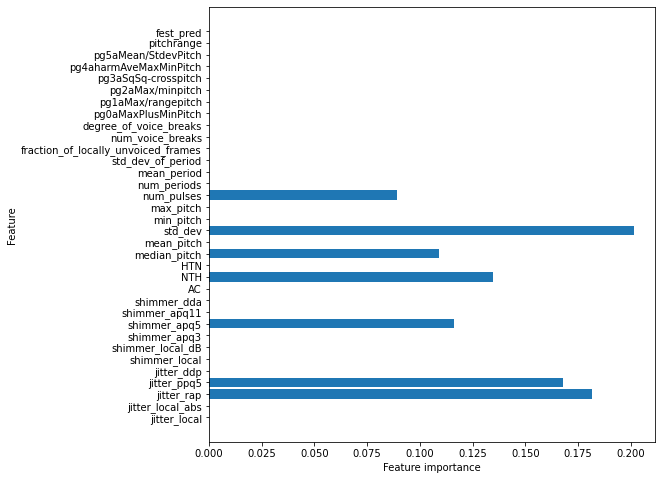

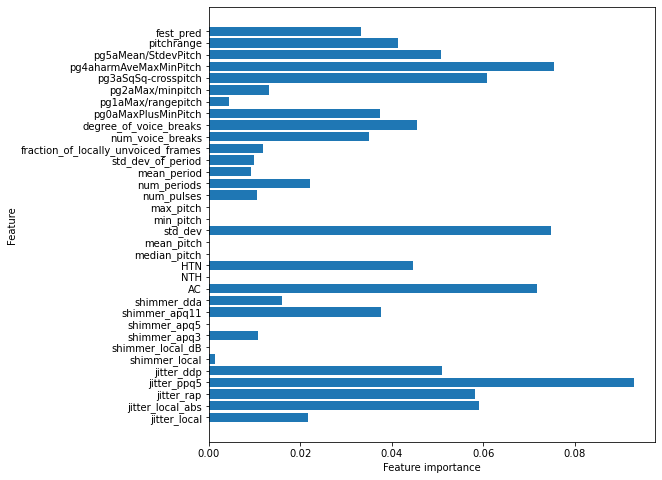

In [57]:
dtbp =  dt_grid_search.best_params_
rfbp = rf_grid_search.best_params_

c, md, msl, mss = dtbp['criterion'], dtbp['max_depth'], dtbp['min_samples_leaf'], dtbp['min_samples_split']
c2, md2, msl2, mss2, ne2 = rfbp['criterion'], rfbp['max_depth'], rfbp['min_samples_leaf'], rfbp['min_samples_split'], rfbp['n_estimators']

# # c, md, msl, mss = 'entropy', None, 6, 10
# # c2, md2, msl2, mss2, ne2 = 'gini', 6, 6, 10, 100

best_dt = DecisionTreeClassifier(criterion=c, max_depth=md, min_samples_leaf=msl, 
                                 min_samples_split=mss, random_state=random_state_val).fit(scaled_data_train, y_train)
print("Decision Tree Feature Importances")
plot_feature_importances(best_dt)

best_rf = RandomForestClassifier(criterion=c2, max_depth=md2, min_samples_leaf=msl2, 
                                 min_samples_split=mss2, n_estimators=ne2, random_state=random_state_val).fit(scaled_data_train, y_train)
print("Random Forest Feature Importances")
plot_feature_importances(best_rf)

In [58]:
dtfi = zip_feature_importances(best_dt, pd.DataFrame(scaled_df_train))
rffi = zip_feature_importances(best_rf, pd.DataFrame(scaled_df_train))
display('decision tree features:', dtfi)
display('random forest features:', rffi)

'decision tree features:'

[(0.0, 'AC'),
 (0.0, 'HTN'),
 (0.0, 'degree_of_voice_breaks'),
 (0.0, 'fest_pred'),
 (0.0, 'fraction_of_locally_unvoiced_frames'),
 (0.0, 'jitter_ddp'),
 (0.0, 'jitter_local'),
 (0.0, 'jitter_local_abs'),
 (0.0, 'max_pitch'),
 (0.0, 'mean_period'),
 (0.0, 'mean_pitch'),
 (0.0, 'min_pitch'),
 (0.0, 'num_periods'),
 (0.0, 'num_voice_breaks'),
 (0.0, 'pg0aMaxPlusMinPitch'),
 (0.0, 'pg1aMax/rangepitch'),
 (0.0, 'pg2aMax/minpitch'),
 (0.0, 'pg3aSqSq-crosspitch'),
 (0.0, 'pg4aharmAveMaxMinPitch'),
 (0.0, 'pg5aMean/StdevPitch'),
 (0.0, 'pitchrange'),
 (0.0, 'shimmer_apq11'),
 (0.0, 'shimmer_apq3'),
 (0.0, 'shimmer_dda'),
 (0.0, 'shimmer_local'),
 (0.0, 'shimmer_local_dB'),
 (0.0, 'std_dev_of_period'),
 (0.08936744908060698, 'num_pulses'),
 (0.10897520458591597, 'median_pitch'),
 (0.11629462102534625, 'shimmer_apq5'),
 (0.13477357667902423, 'NTH'),
 (0.16771791915970788, 'jitter_ppq5'),
 (0.18142304989916508, 'jitter_rap'),
 (0.20144817957023356, 'std_dev')]

'random forest features:'

[(0.0, 'NTH'),
 (0.0, 'max_pitch'),
 (0.0, 'mean_pitch'),
 (0.0, 'median_pitch'),
 (0.0, 'min_pitch'),
 (0.0, 'shimmer_apq5'),
 (0.0, 'shimmer_local_dB'),
 (0.0013607485619241725, 'shimmer_local'),
 (0.004499315021225062, 'pg1aMax/rangepitch'),
 (0.009250261297444645, 'mean_period'),
 (0.009948131923882199, 'std_dev_of_period'),
 (0.010507665101352596, 'num_pulses'),
 (0.010807240718281713, 'shimmer_apq3'),
 (0.011813691167278534, 'fraction_of_locally_unvoiced_frames'),
 (0.01314415916636514, 'pg2aMax/minpitch'),
 (0.016018751752857104, 'shimmer_dda'),
 (0.02158268335337485, 'jitter_local'),
 (0.022141908853793378, 'num_periods'),
 (0.03314311509774672, 'fest_pred'),
 (0.03506658871811386, 'num_voice_breaks'),
 (0.03741013380228536, 'pg0aMaxPlusMinPitch'),
 (0.03753368041650234, 'shimmer_apq11'),
 (0.04125055907769887, 'pitchrange'),
 (0.04470687167440497, 'HTN'),
 (0.04552186256221638, 'degree_of_voice_breaks'),
 (0.05078401436815672, 'pg5aMean/StdevPitch'),
 (0.05092158107872126, 'ji

This is pretty good.
Our engineered predictors don't play a role in the decision tree, but they do make a respectable appearance in the random forest importances.

# Bagging (Bootstrap Aggregation)  
In my understanding, Random Forests are a customized version of bagging, so RF should outperform bagging.  Nevertheless, let's take a look

Results for a few different estimator counts, on our training set (mean scores over crossval)
>NumberEstimators: 10 Recall:0.580 StDev:(0.006)
  >Max score: 0.588 Min score:0.573 
>NumberEstimators: 50 Recall:0.662 StDev:(0.020)
  >Max score: 0.679 Min score:0.634 
>NumberEstimators: 100 Recall:0.705 StDev:(0.018)
  >Max score: 0.718 Min score:0.679 
>NumberEstimators: 500 Recall:0.684 StDev:(0.031)
  >Max score: 0.710 Min score:0.641 
>NumberEstimators: 1000 Recall:0.684 StDev:(0.036)
  >Max score: 0.710 Min score:0.634 


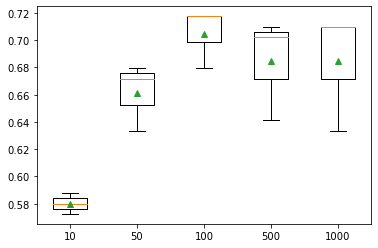

Best average score over cross validation: 0.7048346055979643


In [89]:
# bootstrap aggregation aka bagging
##refer also to this: https://machinelearningmastery.com/bagging-ensemble-with-python/

#Manual parameter search through bagging

####

#from numpy import mean
import pandas as pd
import numpy as np
#np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

from sklearn.model_selection import RepeatedStratifiedKFold

# cv=3
# #For more specificity in the CV, use this...
# #cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=random_state_val)

# #n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# bag_cv_score = cross_val_score(dt_clf, X_train, y_train, cv=cv, scoring = scoring_p)

# get a list of models to evaluate
best_score_bag = 0
def get_models():
    '''create a battery of bagging models with different estimators'''
    dtmodels = dict()
    #rfmodels = dict()
    # define number of trees to consider
    n_trees = [10, 50, 100, 500, 1000]#, 5000, 10000]# time constraints make 5000+ more difficult
    for n in n_trees:
        dtmodels[str(n)] = BaggingClassifier(n_estimators=n, random_state=random_state_val)
        #rfmodels[str(n)] = BaggingClassifier(n_estimators=n) 
    return dtmodels #, rfmodels

def evaluate_model(model, X, y, scoring_p):
    '''evaluate mean crossvalidation scores for a model, test set, scoring system'''
    # define evaluation procedure
    ##cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=random_state_val)
    ##replace cv with this customized version if necessary
    cv = 3
    # evaluate the model 
    #model.fit(X, y)
    scores = cross_val_score(model, X, y, scoring=scoring_p, cv=cv)
    return scores

models = get_models()
results, names = list(), list()
scoring_bag = scoring_p
print('Results for a few different estimator counts, on our training set (mean scores over crossval)')
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, scaled_data_train, y_train, scoring_bag)
    if np.mean(scores)>best_score_bag:
        best_score_bag = np.mean(scores)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>NumberEstimators: %s Recall:%.3f StDev:(%.3f)' % (name, np.mean(scores), np.std(scores)))
    print('  >Max score: %.3f Min score:%.3f ' % (np.max(scores), np.min(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

print("Best average score over cross validation: {}".format(best_score_bag))

In [60]:
best_bag = BaggingClassifier(n_estimators=100).fit(scaled_data_train, y_train)

Using Bagging, we have good results in a short time; with 100 estimators, we get a CV score of 71% recall.

# ADABoost & Gradient Boosting  
These techniques use ensembles of weak learners, each new weak learner crafted to remedy specific miscategorization(s) of previous ones, then put together into an ensemble which does very well at fitting every point.  Outliers have big impact on these models, though overfitting is experimentally less of a problem than expected.  

In [61]:
def display_scores(actual, preds, model_name):
    acc = accuracy_score(actual, preds)
    f1 = f1_score(actual, preds)
    rec = recall_score(actual, preds)
    print("Model: {}".format(model_name))
    if verbose:
        print("Accuracy: {}".format(acc))
    print("Recall: {}".format(rec))
    if verbose:
        print("F1-Score: {}".format(f1))

In [62]:
#ADA & gradient boosting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix, classification_report
from sklearn.metrics import recall_score

adaboost_clf = AdaBoostClassifier(random_state=random_state_val)

# Fit AdaBoostClassifier
adaboost_clf.fit(scaled_data_train, y_train)

# AdaBoost model predictions
adaboost_train_preds = adaboost_clf.predict(scaled_data_train)
adaboost_test_preds = adaboost_clf.predict(scaled_data_test)

In [63]:
gbt_clf = GradientBoostingClassifier(random_state=random_state_val)
# Fit GradientBoostingClassifier
gbt_clf.fit(scaled_data_train, y_train)

# GradientBoosting model predictions
gbt_clf_train_preds = gbt_clf.predict(scaled_data_train)
gbt_clf_test_preds = gbt_clf.predict(scaled_data_test)

In [64]:
#Display results
if verbose:
    print("Training Metrics")
    display_scores(y_train, adaboost_train_preds, model_name='AdaBoost')
    print("")
    display_scores(y_train, gbt_clf_train_preds, model_name='Gradient Boosted Trees')
    print("")
    print("Testing Metrics")
    display_scores(y_test, adaboost_test_preds, model_name='AdaBoost')
    print("")
    display_scores(y_test, gbt_clf_test_preds, model_name='Gradient Boosted Trees')

    ##conf matrices
    print()
    print("Confusion Matrices on Test Set")
    adaboost_confusion_matrix = confusion_matrix(y_test, adaboost_test_preds)
    display(adaboost_confusion_matrix)
    # tn, fp, fn, tp = adaboost_confusion_matrix.ravel()
    # print('TN-FP-FN-TP', tn, fp, fn, tp)
    gbt_confusion_matrix = confusion_matrix(y_test, gbt_clf_test_preds)
    display(gbt_confusion_matrix)

    print()
    print('Classification report on Test Set')
    adaboost_classification_report = classification_report(y_test, adaboost_test_preds)
    print(adaboost_classification_report)
    gbt_classification_report = classification_report(y_test, gbt_clf_test_preds)
    print(gbt_classification_report)

print("Cross validation scores on un-tuned models, for different train-test splits:")
print('Mean Adaboost Cross-Val Score (k=5):')
print(np.mean(cross_val_score(adaboost_clf, scaled_data_train, y_train, cv=cv_def, scoring=scoring_p)))

print('Mean GBT Cross-Val Score (k=5):')
print(np.mean(cross_val_score(gbt_clf, scaled_data_train, y_train, cv=cv_def, scoring=scoring_p)))


Cross validation scores on un-tuned models, for different train-test splits:
Mean Adaboost Cross-Val Score (k=5):
0.6591366439467705
Mean GBT Cross-Val Score (k=5):
0.6997728010386238


ADABoost and Gradient Boosting both performed well; with average recall across cross validataion of 66% and 70% respectively.  
Gradient Boosting appears to be more suited to this analysis, so far.  But, we could always gridsearchcv this too... let's do it!

In [65]:
#Adaboost gridsearch:
#AdaBoostClassifier(random_state=random_state_val)
ada_param_grid = {
    'learning_rate':[0.5, 1.0],
    'n_estimators': [10, 30, 50],
}
ada_grid_search = GridSearchCV(adaboost_clf, ada_param_grid, cv=cv_def, return_train_score=True, scoring = scoring_p, verbose=verb)
ada_grid_search.fit(scaled_data_train, y_train)


ada_gs_training_score1 = np.mean(ada_grid_search.cv_results_['mean_train_score'])
ada_gs_training_score = np.mean(ada_grid_search.score(scaled_data_train, y_train))

# Mean test score
ada_gs_testing_score = np.mean(ada_grid_search.score(scaled_data_test, y_test))

print(f"Mean Training Score ADA:  {ada_gs_training_score1 :.2%}") #{ada_gs_training_score :.2%} and
print(f"Mean Test Score ADA: {ada_gs_testing_score :.2%}")
print("Optimal Parameters for ADA Grid Search (Training):", ada_grid_search.best_params_)
print()


Mean Training Score ADA:  76.79%
Mean Test Score ADA: 63.78%
Optimal Parameters for ADA Grid Search (Training): {'learning_rate': 0.5, 'n_estimators': 30}



With a little gridsearch, we can get crossvalidation recall score up to 77% (with 64% test recall) for Adaboost; pretty good.  

In [66]:
#make best ada
lr = ada_grid_search.best_params_['learning_rate'] 
ne = ada_grid_search.best_params_['n_estimators']
best_ada = AdaBoostClassifier(random_state=random_state_val, learning_rate=lr, n_estimators=ne).fit(scaled_data_train, y_train)

In [67]:
y_pred = best_ada.predict(scaled_data_train)
recall(y_pred, y_train)
# y_pred = best_ada.predict(test_df_sc)
# recall(y_pred, y_test)

0.7616580310880829

None

[(0.0, 'AC'),
 (0.0, 'NTH'),
 (0.0, 'fest_pred'),
 (0.0, 'jitter_local'),
 (0.0, 'max_pitch'),
 (0.0, 'mean_pitch'),
 (0.0, 'min_pitch'),
 (0.0, 'num_pulses'),
 (0.0, 'num_voice_breaks'),
 (0.0, 'pg1aMax/rangepitch'),
 (0.0, 'pg2aMax/minpitch'),
 (0.0, 'pg4aharmAveMaxMinPitch'),
 (0.0, 'shimmer_apq3'),
 (0.0, 'shimmer_local_dB'),
 (0.0, 'std_dev_of_period'),
 (0.03333333333333333, 'jitter_ddp'),
 (0.03333333333333333, 'jitter_local_abs'),
 (0.03333333333333333, 'jitter_rap'),
 (0.03333333333333333, 'mean_period'),
 (0.03333333333333333, 'pg3aSqSq-crosspitch'),
 (0.03333333333333333, 'pg5aMean/StdevPitch'),
 (0.03333333333333333, 'pitchrange'),
 (0.03333333333333333, 'shimmer_apq5'),
 (0.03333333333333333, 'shimmer_dda'),
 (0.03333333333333333, 'shimmer_local'),
 (0.03333333333333333, 'std_dev'),
 (0.06666666666666667, 'HTN'),
 (0.06666666666666667, 'degree_of_voice_breaks'),
 (0.06666666666666667, 'fraction_of_locally_unvoiced_frames'),
 (0.06666666666666667, 'num_periods'),
 (0.066666

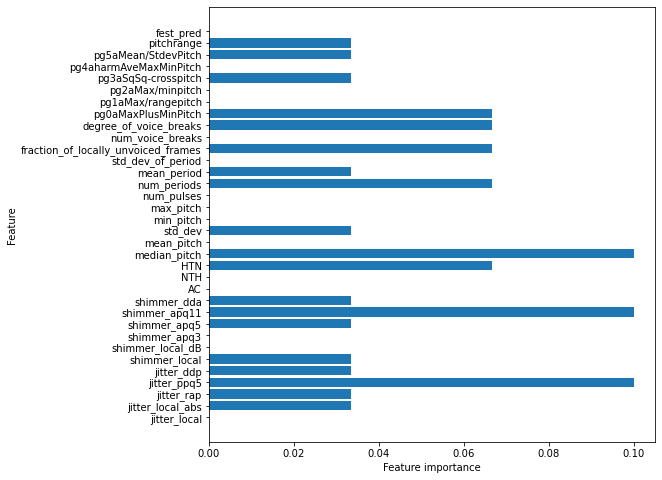

In [68]:
#best ada feature importances
display(plot_feature_importances(best_ada))
ordered_feat_imp_ada = zip_feature_importances(best_ada, scaled_df_train)
ordered_feat_imp_ada

In [69]:
#GBT gridsearch:
#GradientBoostingClassifier(random_state=random_state_val)
gbt_param_grid = {
    'learning_rate':[0.3, 1],
    'n_estimators': [30, 50, 100],
    'min_samples_split' : [3,5],
    'max_depth' :[7, 10],
}
gbt_grid_search = GridSearchCV(gbt_clf, gbt_param_grid, cv=cv_def, return_train_score=True, scoring = scoring_p, verbose=verb)
gbt_grid_search.fit(scaled_data_train, y_train)

gbt_gs_training_score = np.mean(gbt_grid_search.score(scaled_data_train, y_train))
gbt_gs_training_score1 = np.mean(gbt_grid_search.cv_results_['mean_train_score'])

# Mean test score
gbt_gs_testing_score = np.mean(gbt_grid_search.score(scaled_data_test, y_test))

print(f"Mean Training Score GBT:  {gbt_gs_training_score1 :.2%}")#{gbt_gs_training_score :.2%} and
print(f"Mean Test Score GBT: {gbt_gs_testing_score :.2%}")
print("Optimal Parameters for GBT Grid Search (Training):", gbt_grid_search.best_params_)
print()

Mean Training Score GBT:  100.00%
Mean Test Score GBT: 78.74%
Optimal Parameters for GBT Grid Search (Training): {'learning_rate': 1, 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 50}



With gridsearchcv on GradientBoosting, we can get recall score up to 100% on crossvalidation and 79% on test set. Nice!  
Let's check out feature importances there.

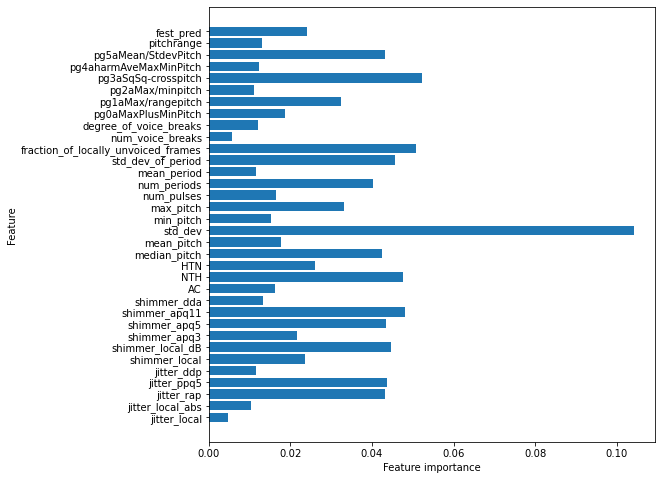

In [70]:
#make best gbt
lr = gbt_grid_search.best_params_['learning_rate'] 
md = gbt_grid_search.best_params_['max_depth'] 
mss = gbt_grid_search.best_params_['min_samples_split'] 
ne = gbt_grid_search.best_params_['n_estimators']
best_gbt = GradientBoostingClassifier(random_state=random_state_val, learning_rate=lr, max_depth=md, 
                                      min_samples_split=mss, n_estimators=ne)
best_gbt.fit(scaled_data_train, y_train)
plot_feature_importances(best_gbt)

In [71]:
ordered_feat_imp = zip_feature_importances(best_gbt, scaled_df_train)
ordered_feat_imp

[(0.004762863212017615, 'jitter_local'),
 (0.0056024960470678125, 'num_voice_breaks'),
 (0.010255760863273563, 'jitter_local_abs'),
 (0.011080756662070552, 'pg2aMax/minpitch'),
 (0.011447094086152262, 'mean_period'),
 (0.011459981249335168, 'jitter_ddp'),
 (0.012133219444730458, 'degree_of_voice_breaks'),
 (0.012271320868913882, 'pg4aharmAveMaxMinPitch'),
 (0.012958887451551231, 'pitchrange'),
 (0.013293267372999918, 'shimmer_dda'),
 (0.015131384013964327, 'min_pitch'),
 (0.016191385964304653, 'AC'),
 (0.016364664729472803, 'num_pulses'),
 (0.0177798894939742, 'mean_pitch'),
 (0.018755219461622726, 'pg0aMaxPlusMinPitch'),
 (0.02158244848276967, 'shimmer_apq3'),
 (0.023549391695907747, 'shimmer_local'),
 (0.024104108311312742, 'fest_pred'),
 (0.02600704962360257, 'HTN'),
 (0.03250136794144035, 'pg1aMax/rangepitch'),
 (0.03322629962944739, 'max_pitch'),
 (0.04017693926930921, 'num_periods'),
 (0.042497250699351716, 'median_pitch'),
 (0.04317237317241156, 'pg5aMean/StdevPitch'),
 (0.04317

# XGBoost  
Yes, the show you've all been waiting for.  Let's see what this popular boosting model can do here.

In [72]:
from xgboost import XGBClassifier
clf = XGBClassifier(random_state=random_state_val)

# Fit XGBClassifier
clf.fit(scaled_data_train, y_train, eval_metric='logloss')

# Predict on training and test sets
training_preds = clf.predict(scaled_data_train)
test_preds = clf.predict(scaled_data_test)

# Accuracy of training and test sets
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

#recall 
training_recall = recall_score(y_train, training_preds)
test_recall = recall_score(y_test, test_preds)

#crossval avg
scores = evaluate_model(clf, scaled_data_train, y_train, scoring_p)

print("For un-optimized XGBoost, mean recall across crossvalidation:",  np.mean(scores))

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))
print('Training Recall: {:.4}%'.format(training_recall * 100))
print('Validation Recall: {:.4}%'.format(test_recall * 100))
print()

##tune parameters
param_grid = {
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [12, 24],
    'min_child_weight': [1],
    'subsample': [0.5,0.7],
    'n_estimators': [200, 300],
}
grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=cv_def, return_train_score=True, n_jobs=1 )#can update n_jobs if have access to parallel processors
grid_clf.fit(scaled_data_train, y_train, eval_metric='logloss')


xgb_gs_training_score1 = np.mean(grid_clf.cv_results_['mean_train_score'])
xgb_gs_training_score = np.mean(grid_clf.score(scaled_data_train, y_train))

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(scaled_data_train)
test_preds = grid_clf.predict(scaled_data_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)
training_recall = recall_score(y_train, training_preds)
test_recall = recall_score(y_test, test_preds)

if verbose:
    print('')
    print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
    print('Validation Accuracy: {:.4}%'.format(test_accuracy * 100))

    print('Training Recall: {:.4}%'.format(training_recall * 100))
    print('Validation Recall: {:.4}%'.format(test_recall * 100))

print('GridsearchCV (parameter optimized) mean recall: {xgb_gs_training_score1:.2%}', )#,xgb_gs_training_score, ' or '

[10:11:05] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:11:05] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:11:06] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For un-optimized XGBoost, mean recall across crossvalidation: 0.707379134860051
Training Accuracy: 100.0%
Validation accuracy: 66.54%

In [73]:
xgb_gs_training_score = np.mean(grid_clf.score(scaled_data_train, y_train))

# Mean test score
xgb_gs_testing_score = np.mean(grid_clf.score(scaled_data_test, y_test))

print(f"Mean Training Score XGB: {xgb_gs_training_score :.2%}")
print(f"Mean Training Score XGB: {xgb_gs_training_score1 :.2%}")
print(f"Mean Test Score XGB: {xgb_gs_testing_score :.2%}")

Mean Training Score XGB: 100.00%
Mean Training Score XGB: 100.00%
Mean Test Score XGB: 68.08%


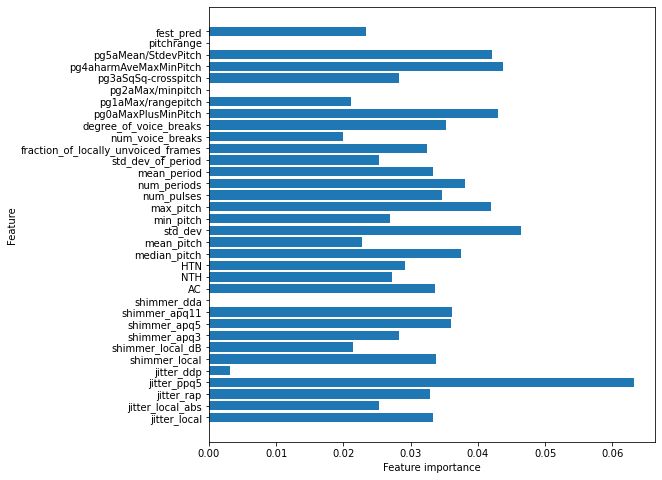

In [74]:
lr=best_parameters['learning_rate']
md=best_parameters['max_depth']
mcw=best_parameters['min_child_weight']
ne=best_parameters['n_estimators']
ss=best_parameters['subsample']
best_xgb = XGBClassifier(learning_rate=lr,max_depth=md,min_child_weight=mcw,n_estimators=ne,subsample=ss, random_state=random_state_val)
best_xgb.fit(scaled_data_train, y_train, eval_metric='logloss')
plot_feature_importances(best_xgb)
#clfbest.feature_importances_
#clf.feature_importances_

In [75]:
ordered_feat_imp_xgb = zip_feature_importances(best_xgb, scaled_df_train)
ordered_feat_imp_xgb

[(0.0, 'pg2aMax/minpitch'),
 (0.0, 'pitchrange'),
 (0.0, 'shimmer_dda'),
 (0.003205143, 'jitter_ddp'),
 (0.019932166, 'num_voice_breaks'),
 (0.0211537, 'pg1aMax/rangepitch'),
 (0.021431828, 'shimmer_local_dB'),
 (0.022830404, 'mean_pitch'),
 (0.023371344, 'fest_pred'),
 (0.0252925, 'jitter_local_abs'),
 (0.025361344, 'std_dev_of_period'),
 (0.02698371, 'min_pitch'),
 (0.027172849, 'NTH'),
 (0.028263196, 'pg3aSqSq-crosspitch'),
 (0.028308641, 'shimmer_apq3'),
 (0.029131433, 'HTN'),
 (0.032431956, 'fraction_of_locally_unvoiced_frames'),
 (0.03290938, 'jitter_rap'),
 (0.03333602, 'jitter_local'),
 (0.033353914, 'mean_period'),
 (0.033570893, 'AC'),
 (0.03383512, 'shimmer_local'),
 (0.03461161, 'num_pulses'),
 (0.035326462, 'degree_of_voice_breaks'),
 (0.035970215, 'shimmer_apq5'),
 (0.03613775, 'shimmer_apq11'),
 (0.037559573, 'median_pitch'),
 (0.038152616, 'num_periods'),
 (0.041988377, 'max_pitch'),
 (0.042063754, 'pg5aMean/StdevPitch'),
 (0.042973656, 'pg0aMaxPlusMinPitch'),
 (0.04372

In [76]:
# testing this on the actual test set
test_df_eng = pred_eng_feat(test_df)
#test_df_eng
test_df_y = test_df_eng['class_info']
test_df_x = test_df_eng.drop(['ID', 'class_info'], axis=1)
#test_df_x.columns
test_df_sc = scaler.transform(test_df_x)
test_preds = best_xgb.predict(test_df_sc)


#training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(test_df_y, test_preds)
#training_recall = recall_score(y_train, training_preds)
test_recall = recall_score(test_df_y, test_preds)

print('')
#print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Test Accuracy: {:.4}%'.format(test_accuracy * 100))

#print('Training Recall: {:.4}%'.format(training_recall * 100))
print('Test Recall: {:.4}%'.format(test_recall * 100))


Test Accuracy: 53.57%
Test Recall: 53.57%


### XGBoost results:  
XGBoost fits extremely well to training data, averaging 100% across CV, while managing a rather high recall rate on the test set. While the 100% training set recall might indicate overfitting, the still-respectable validation recall (74%) stands.  Test set recall(54%) might be taken with as much salt as you like, since it's 100% PWP.   
Taking a look at the feature importances the top features are: jitter_ppq5, std_dev(of pitch), jitter_ddp, NTH, max_pitch, and median_pitch.

# Evaluating models on test_df

In [117]:
models = [logreg,
best_knn,
best_dt,
best_rf,
best_bag,
best_ada,
best_gbt,
best_xgb]

#t_X = test_df.drop(['class_info', 'ID'], axis=1)
#t_y = test_df['class_info']

test_df_eng = pred_eng_feat(test_df)
#test_df_eng
test_df_y = test_df_eng['class_info']
test_df_x = test_df_eng.drop(['ID', 'class_info'], axis=1)
#test_df_x.columns
test_df_sc = scaler.transform(test_df_x)
t_X = test_df_sc
t_y = test_df_y

testscores=[]

def eval_model_on_test(model, t_X=t_X, t_y=t_y):
        y_preds = model.predict(t_X)
        #score_suite(t_y, y_preds)
        #print(recall(t_y, y_preds))
        return recall(t_y, y_preds)
        
for model in models:
    r = eval_model_on_test(model, t_X, t_y)
    testscores.append(r)
    print("Results for {}: \n  recall score:{:.3}%".format(model, 100*r))
    print('------')


Results for LogisticRegression(max_iter=500, multi_class='ovr', random_state=7): 
  recall score:32.7%
------
Results for KNeighborsClassifier(n_neighbors=13): 
  recall score:76.8%
------
Results for DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=2,
                       min_samples_split=40, random_state=7): 
  recall score:91.1%
------
Results for RandomForestClassifier(max_depth=2, n_estimators=30, random_state=7): 
  recall score:89.3%
------
Results for BaggingClassifier(n_estimators=100): 
  recall score:58.9%
------
Results for AdaBoostClassifier(learning_rate=0.5, n_estimators=30, random_state=7): 
  recall score:39.3%
------
Results for GradientBoostingClassifier(learning_rate=1, max_depth=10, min_samples_split=5,
                           n_estimators=50, random_state=7): 
  recall score:54.2%
------
Results for XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_

Logistic Regression: logregmeanscore: 68.96%
KNN: knngs_u_trainscore: 60.2%
Decision Tree: dt_gs_training_score: 73.35%
Random Forest: rf_gs_training_score: 90.14%
Bagging: best_score_bag: 70.48%
ADA Boost: ada_gs_training_score1: 76.79%
Gradient Boost: gbt_gs_training_score1: 100.0%
XGBoost: xgb_gs_training_score1: 100.0%


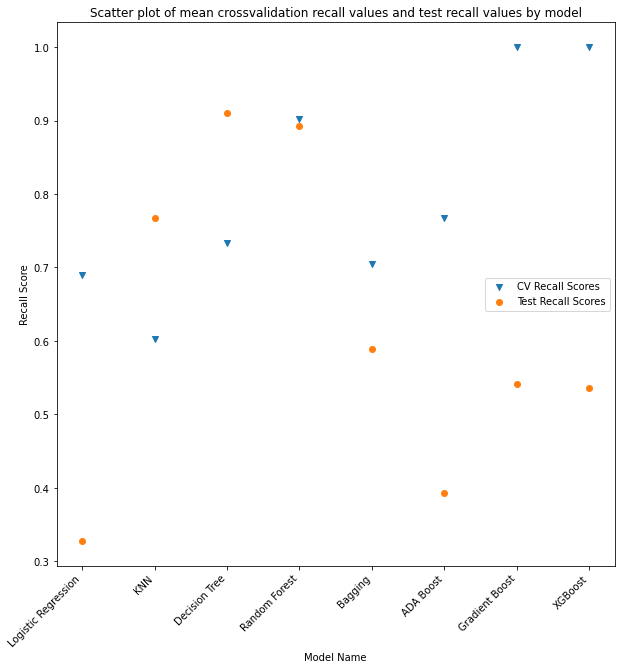

In [141]:
#recapping models crossvalidation average recall scores:
cvscores = ['logregmeanscore', 'knngs_u_trainscore', 'dt_gs_training_score', 'rf_gs_training_score', 'best_score_bag',
            'ada_gs_training_score1', 'gbt_gs_training_score1', 'xgb_gs_training_score1']
models = ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'Bagging', 'ADA Boost', 'Gradient Boost', 
          'XGBoost']
cvscorevals = [eval(x) for x in cvscores]

for model, scorename in zip(models, cvscores):
    print('{}: {}: {:.4}%'.format(model, scorename, 100*float(eval(scorename))))
    


plt.figure(figsize=(10, 10))
plt.xticks(rotation=45, ha='right')
plt.scatter(models, cvscorevals, marker = 'v', label='CV Recall Scores')
plt.scatter(models, testscores, label = 'Test Recall Scores')#, markersize=4
plt.title("Scatter plot of mean crossvalidation recall values and test recall values by model")
plt.xticks(range(0, len(cvscorevals)), models)
plt.xlabel('Model Name')
plt.ylabel('Recall Score')
plt.legend(loc=5)
plt.show()

# Results  
The models' cross validation recall scores are (crossvalidation average and test_df respectively):
- logisticregression: 69%, 33%
- knn: 60%, 77%
- decision tree: 73%, 91%
- random forests: 90%, 89%
- bagging: 70%, 59%
- adaboost: 77%, 39% 
- gradientboost: 100%, 54%
- xgboost: 100%, 54%

Concerns may include that since the actual test set is 100% PWP, it doesn't represent a good discernment.  Furthermore, since there are more than one sample for each patient, this likely leaves room for overfitting and generating artificially high train/validation scores.  
However, random forest model presents a strong case, since it scored high on both the training set and test set. We will perform the final wrap-up on that model.

# Features
Each model attributes different importance to different features, but some features which appear with high importance frequently include std_dev(of pitch), jitter, and noise-to-harmonic.   
Gradient Boosting model, which did well on training set, had these top 6 features with top importance: mean_pitch, shimmer_apq5, std_dev_of_period, HTN, jitter_rap, AC.  

Random forest model, our declared best, had these top 5 features with greatest importance: jitter_ppq5, pg4aharmAveMaxMinPitch, std_dev (of pitch), AC, and pg3aSqSq-crosspitch.  

# Pipeline  
To share this optimized and fit model, we can assemble a pipeline to go from starting data to finish.  
NB: Results below will -not- match above results, since the same random seed is not being used (results shouldn't depend on a fortuitous seed).

In [78]:
# repasting pred_eng_feat from above for reference
# def pred_eng_feat(df):
#     '''creates the aforementioned engineered feature columns, given a dataframe'''
#     df['pg0aMaxPlusMinPitch'] = df['max_pitch'] + df['min_pitch']
#     #this potentially could be different than 2*mean, based on amount of time spent on those pitches

#     df['pg1aMax/rangepitch'] = (df['max_pitch']/(df['max_pitch']-df['min_pitch']))

#     df['pg2aMax/minpitch'] = ((df['max_pitch']/(df['min_pitch'])))

#     df['pg3aSqSq-crosspitch'] = (df['max_pitch']**2 + df['min_pitch'] **2 -2*df['max_pitch']*df['min_pitch'])

#     df['pg4aharmAveMaxMinPitch'] = ((df['max_pitch']*(df['min_pitch']))**(1/2) )

#     df['pg5aMean/StdevPitch'] = df['mean_pitch']/df['std_dev']
    
#     df['pitchrange'] = df['max_pitch']-df['min_pitch']
    
#     df['fest_pred'] = df['jitter_ppq5']*df['std_dev_of_period']
    
#     #train_df['pred_eng_feater0']O
#     #gencols = ['pg0a', 'pg1a', 'pg2a', 'pg3a', 'pg4a']
#     return df

In [79]:
# for pipeline, make class wrapper for the engineered features

from sklearn.base import TransformerMixin, BaseEstimator
#class customFeats(object):
class customFeats(TransformerMixin, BaseEstimator):
    '''object wrapper for engineered features, suitable for pipelining'''
    def transform(self, X):
        X = pred_eng_feat(X)
        return X

    def fit(self, X, y=None):
        return self
    
class dropFeats(TransformerMixin, BaseEstimator):
    '''object wrapper for column omission from training set'''
    def transform(self, X):
        dropcols = ['ID', 'UPDRS', 'class_info']
        for c in dropcols:
            try:
                X = X.drop(c, axis=1)
            except:
                pass
        return X
    
    def fit(self, X, y=None):
        return self

In [80]:
#Fresh import of the train and test data set (to simulate a brand new dataset)
# in order to demonstrate functionality of pipeline
fin_train_df = pd.read_csv('data/Parkinson_Multiple_Sound_Recording/train_data.txt', sep=",", header=None, names=colheadings_train)
fin_test_df = pd.read_csv('data/Parkinson_Multiple_Sound_Recording/test_data.txt', sep=",", header=None, names=colheadings_test)
ftx = fin_train_df.drop(['ID', 'UPDRS', 'class_info'], axis=1)

fty = fin_train_df['class_info']
ftx.columns

ftx_test = fin_test_df.drop(['ID', 'class_info'], axis=1)
fty_test = fin_test_df['class_info']

In [81]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

pipe_fin = Pipeline(steps=[
    ('dropFeats', dropFeats()),
    ('customFeats', customFeats()),
    ('scaler', StandardScaler()), 
    ('RFclf', RandomForestClassifier( criterion='gini', 
                                    max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=30)) 
    #random_state=random_state_val,
    #('GBclf', GradientBoostingClassifier(learning_rate=0.3, max_depth=7, min_samples_split=3, n_estimators=50, random_state=random_state_val))
    #('GBclf', GradientBoostingClassifier(learning_rate=1, max_depth=10, min_samples_split=5, n_estimators=50, random_state=random_state_val))
    ])

#    

pipe_fin.fit(ftx, fty)
print(pipe_fin.score(ftx, fty))
print(pipe_fin.score(ftx_test, fty_test))
#print(pipe_fin.get_params())
train_preds = pipe_fin.predict(ftx)
test_preds = pipe_fin.predict(ftx_test)
print('recall score training:', recall( fty, train_preds))
print('recall score test:', recall( fty_test, test_preds))


0.6807692307692308
0.2976190476190476
recall score training: 0.7442307692307693
recall score test: 0.2976190476190476


In [82]:
import pickle
with open('clf_model_1.pkl', 'wb') as f:
    pickle.dump(pipe_fin,f)

In [83]:
with open('clf_model_1.pkl', 'rb') as f:
    unpickled_pipe = pickle.load(f)
    
print(unpickled_pipe.score(ftx_test, fty_test))

if unpickled_pipe.score(ftx_test, fty_test) == pipe_fin.score(ftx_test, fty_test):
    print('Pickled and unpickled models produce same scores!')

0.2976190476190476
Pickled and unpickled models produce same scores!


# Discussion  
Existing UPDRS evaluation brings in many non-speech-related factors into account; however, it doesn't establish as much specificity into speech impairment as our approach.  
The features we have identified as being most influential may be further incorporated or given more weight by physicians and speech pathologists in diagnosing PD.  Furthermore, automated analysis (like the model developed here) can identify features of voice data that humans may not identify in real-time.  

Further analysis could pursue two important extensions.  
1) Differential diagnosis.  For patients with dysphonia, the cause may be PD, but also could be caused by other neurological disorders or disorders of other systems.  In order to avoid misdiagnosing these disorders as PD, we could endeavor to expand out dataset from binary classification (PD vs healthy) to include other diseases with symptomatic crossover with PD, or which commonly have misdiagnosis issues with PD.  

2) Early diagnosis.  For many health conditions, prevention is optimal, with early diagnosis being desirable in order to apply any treatment to mitigate progress of symptoms as soon as possible.  To this end, we could expand a study to obtain voice samples over time, identifying which patients eventually develop PD, and then training models on earlier-acquired samples to identify any early-warning signs that may be missed by traditional methods.    

## Visualizations for presentation

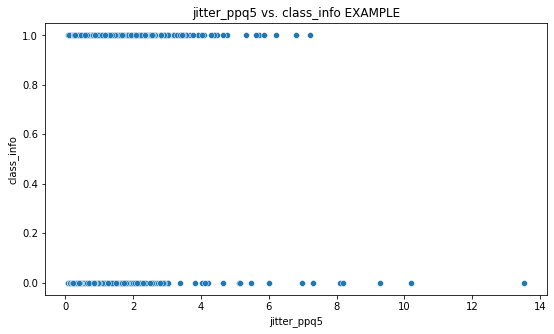

In [143]:
plt.figure(figsize=(9, 5))
col = 'jitter_ppq5'
sns.scatterplot(x=col, y=target, data=df).set_title('{} vs. {} EXAMPLE'.format(col, target))
plt.ticklabel_format(style='plain')#style='plain', 'sci', 'scientific'

Text(0.5, 1.0, 'jitter_ppq5 vs. class_info EXAMPLE')

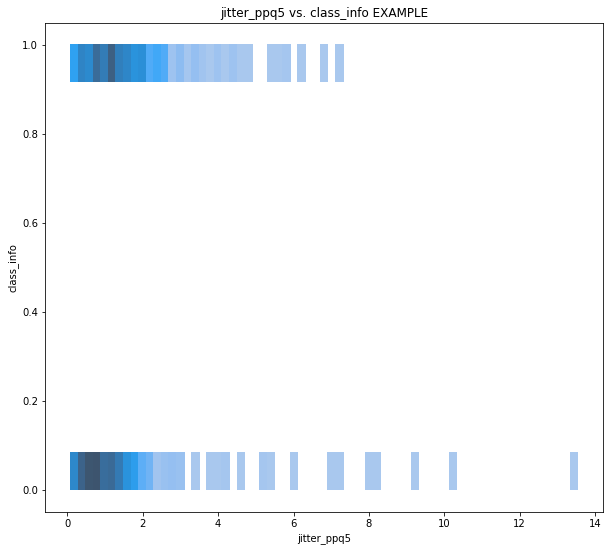

In [146]:
plt.figure(figsize=(10, 9))
sns.histplot(x=col, y=target, data=df).set_title('{} vs. {} EXAMPLE'.format(col, target))

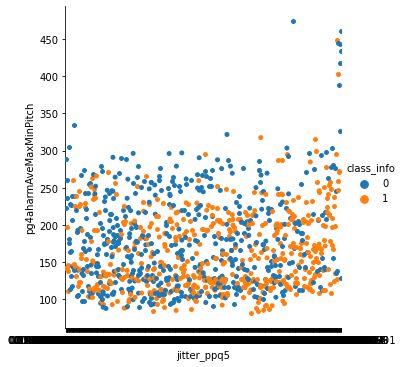

In [160]:
dset = train_df[['jitter_ppq5', 'pg4aharmAveMaxMinPitch', 'class_info']]
#dset = sns.load_dataset(dset)
sns.catplot(x="jitter_ppq5", y="pg4aharmAveMaxMinPitch", data=dset, hue='class_info')